##############################################################################
##############################################################################
#                ESTIMAÇÃO DE MODELOS HIERÁRQUICOS LINEARES                  #
#                    DE DOIS NÍVEIS COM DADOS AGRUPADOS                      #
##############################################################################
##############################################################################


In [1]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import statsmodels.api as sm # estimação de modelos
from pymer4.models import Lmer # estimação de modelos HLM3 neste código
from scipy import stats # estatística chi2
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from scipy.stats import gaussian_kde # inserção de KDEs em gráficos
from matplotlib.gridspec import GridSpec # plotagem de gráficos separados
import time # definição do intervalo de tempo entre gráficos com animação
import imageio # para geração de figura GIF
from tqdm import tqdm # adiciona um indicador de progresso do código

In [2]:
# Carregamento da base de dados 'desempenho_aluno_escola'
df_aluno_escola = pd.read_csv("/home/usp_ds_analytics/modelagem_multinivel/data/desempenho_aluno_escola.csv", delimiter=',')

# Visualização da base de dados 'desempenho_aluno_escola'
df_aluno_escola.head()

,estudante,escola,desempenho,horas,texp
0,1,1,25.0,11,3.6
1,2,1,52.0,23,3.6
2,3,1,52.0,25,3.6
3,4,1,30.0,14,3.6
4,5,1,51.0,24,3.6


In [3]:
# Características das variáveis do dataset
df_aluno_escola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   estudante   358 non-null    int64  
 1   escola      358 non-null    int64  
 2   desempenho  358 non-null    float64
 3   horas       358 non-null    int64  
 4   texp        358 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 14.1 KB


In [4]:
df_aluno_escola['escola'].value_counts(normalize=True)

escola
5     0.134078
3     0.134078
1     0.131285
9     0.122905
8     0.097765
10    0.092179
6     0.083799
7     0.078212
2     0.069832
4     0.055866
Name: proportion, dtype: float64

In [5]:
# Atribuição de categorias para as variáveis 'estudante' e 'escola'
df_aluno_escola['estudante'] = df_aluno_escola['estudante'].astype('category')
df_aluno_escola['escola'] = df_aluno_escola['escola'].astype('category')

In [6]:
# Características das variáveis do dataset
df_aluno_escola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   estudante   358 non-null    category
 1   escola      358 non-null    category
 2   desempenho  358 non-null    float64 
 3   horas       358 non-null    int64   
 4   texp        358 non-null    float64 
dtypes: category(2), float64(2), int64(1)
memory usage: 20.8 KB


In [7]:
# Estatísticas univariadas
df_aluno_escola.describe()

,desempenho,horas,texp
count,358.000000,358.000000,358.000000
mean,41.554190,18.997207,5.161173
std,23.225896,6.368910,3.682676
min,6.500000,4.000000,1.900000
25%,21.000000,14.000000,1.900000
50%,35.500000,20.000000,3.600000
75%,59.000000,24.000000,7.500000
max,100.000000,31.000000,13.000000


In [8]:
# In[1.1]: Estudo sobre o desbalanceamento dos dados por escola
df_aluno_escola.groupby('escola')['estudante'].count().reset_index()

/tmp/ipykernel_2709/3318819849.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_aluno_escola.groupby('escola')['estudante'].count().reset_index()


,escola,estudante
0,1,47
1,2,25
2,3,48
3,4,20
4,5,48
5,6,30
6,7,28
7,8,35
8,9,44
9,10,33


In [9]:
# In[1.2]: Desempenho médio dos estudantes por escola
desempenho_medio = df_aluno_escola.groupby('escola')['desempenho'].mean().reset_index()
desempenho_medio

/tmp/ipykernel_2709/3820164476.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desempenho_medio = df_aluno_escola.groupby('escola')['desempenho'].mean().reset_index()


,escola,desempenho
0,1,36.765957
1,2,21.400000
2,3,67.125000
3,4,55.325000
4,5,19.270833
5,6,33.966667
6,7,57.532143
7,8,75.428571
8,9,18.556818
9,10,38.590909


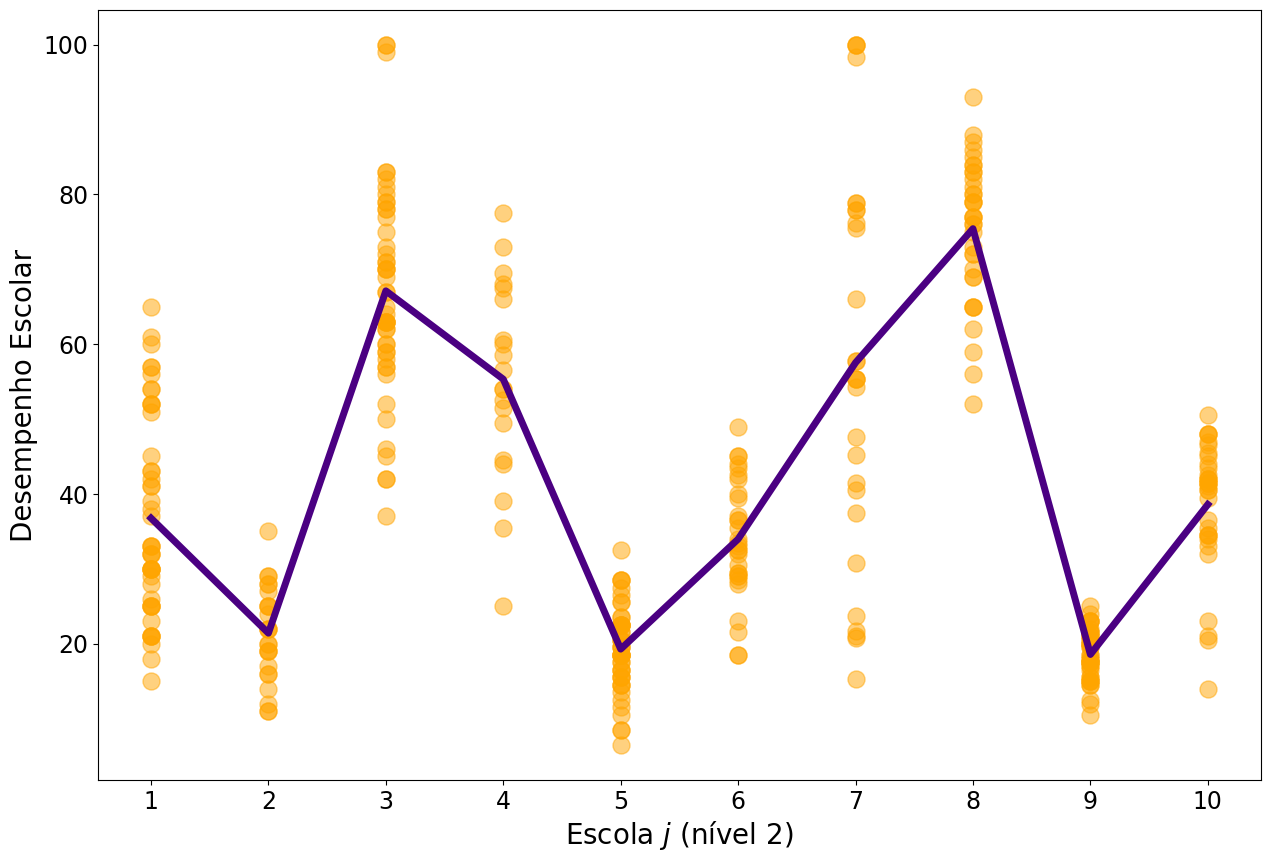

In [10]:
# In[1.3]: Gráfico do desempenho escolar médio dos estudantes por escola
plt.figure(figsize=(15,10))
plt.plot(desempenho_medio['escola'], desempenho_medio['desempenho'],
         linewidth=5, color='indigo')
plt.scatter(df_aluno_escola['escola'], df_aluno_escola['desempenho'],
            alpha=0.5, color='orange', s = 150)
plt.xlabel('Escola $j$ (nível 2)', fontsize=20)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xticks(desempenho_medio.escola, fontsize=17)
plt.yticks(fontsize=17)
plt.show()

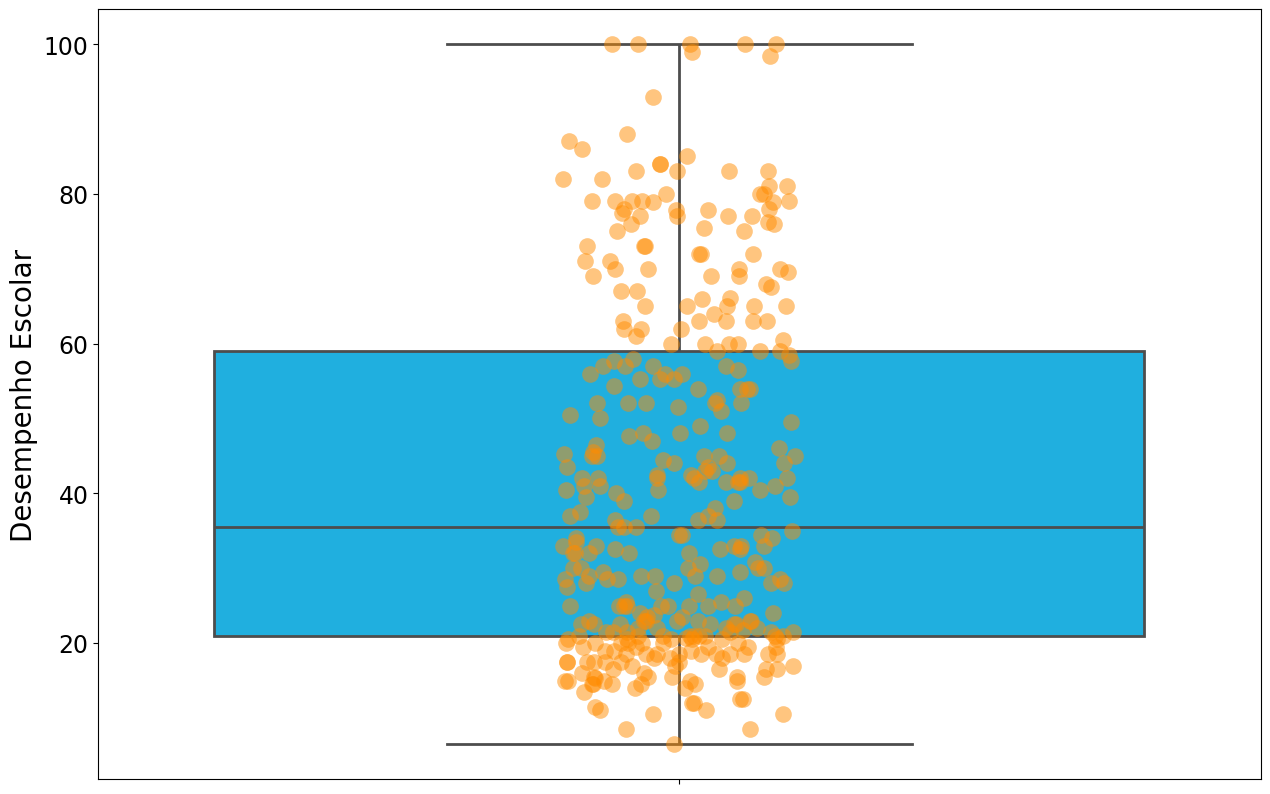

In [11]:
# In[1.4]: Boxplot da variável dependente ('desempenho')
plt.figure(figsize=(15,10))
sns.boxplot(data=df_aluno_escola, y='desempenho',
            linewidth=2, orient='v', color='deepskyblue')
sns.stripplot(data=df_aluno_escola, y='desempenho',
              color='darkorange', jitter=0.1, size=12, alpha=0.5)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.yticks(fontsize=17)
plt.show()


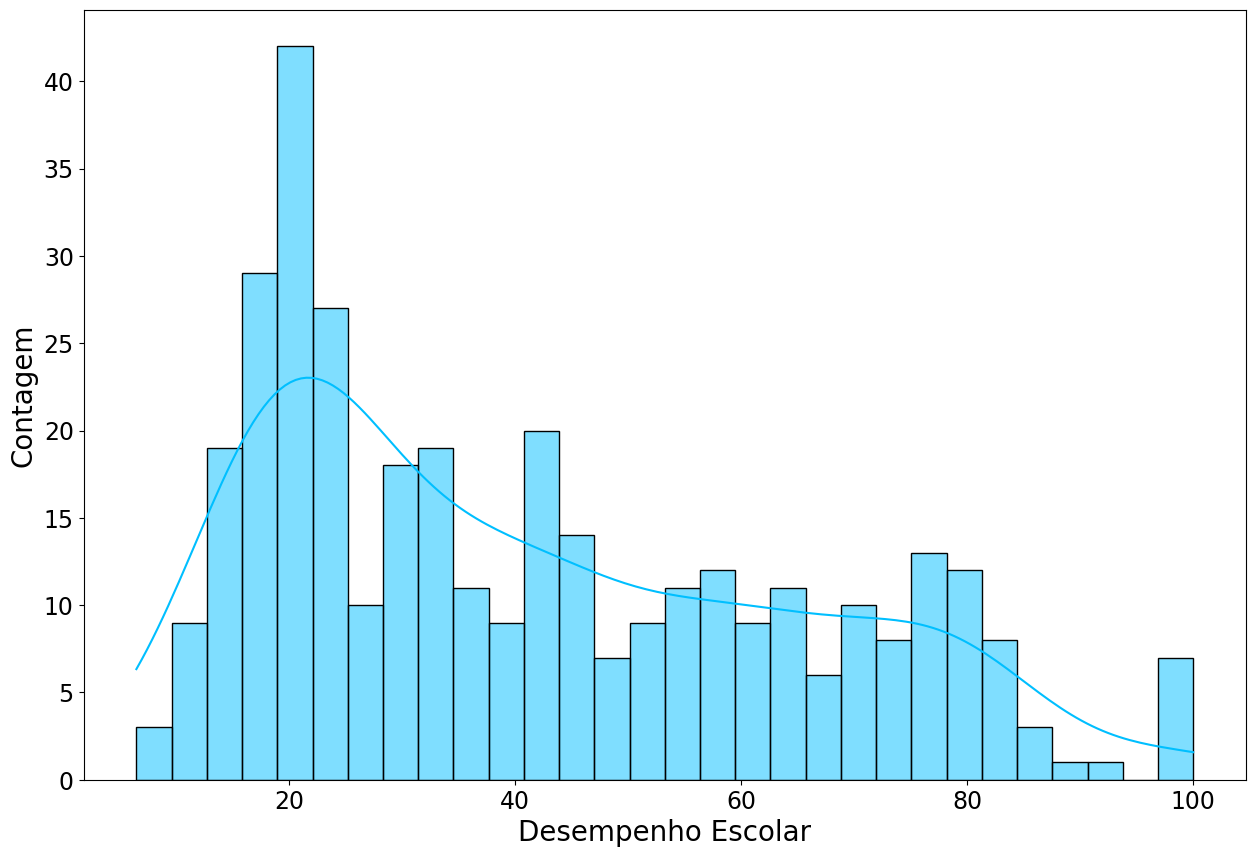

In [12]:
# In[1.5]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho'), com histograma
plt.figure(figsize=(15,10))
sns.histplot(data=df_aluno_escola['desempenho'], kde=True,
             bins=30, color='deepskyblue')
plt.xlabel('Desempenho Escolar', fontsize=20)
plt.ylabel('Contagem', fontsize=20)
plt.tick_params(axis='y', labelsize=17)
plt.tick_params(axis='x', labelsize=17)
plt.show()

/tmp/ipykernel_2709/2725873080.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_aluno_escola, x='escola', y='desempenho',


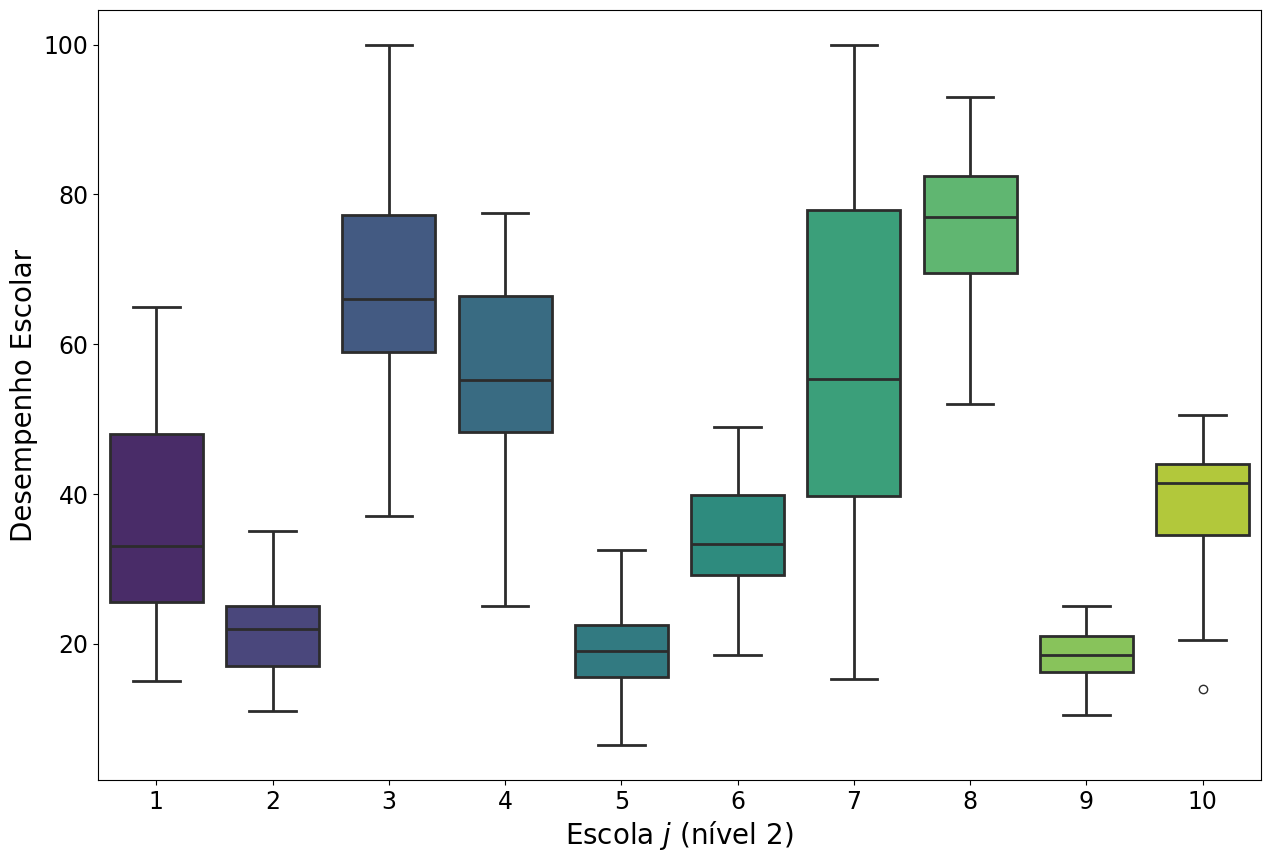

In [13]:
# In[1.6]: Boxplot da variável dependente ('desempenho') por escola
plt.figure(figsize=(15,10))
sns.boxplot(data=df_aluno_escola, x='escola', y='desempenho',
            linewidth=2, orient='v', palette='viridis')
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xlabel('Escola $j$ (nível 2)', fontsize=20)
plt.tick_params(axis='y', labelsize=17)
plt.tick_params(axis='x', labelsize=17)
plt.show()

/tmp/ipykernel_2709/2840162917.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_aluno_escola, y='desempenho',
/tmp/ipykernel_2709/2840162917.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_aluno_escola, x='escola', y='desempenho',


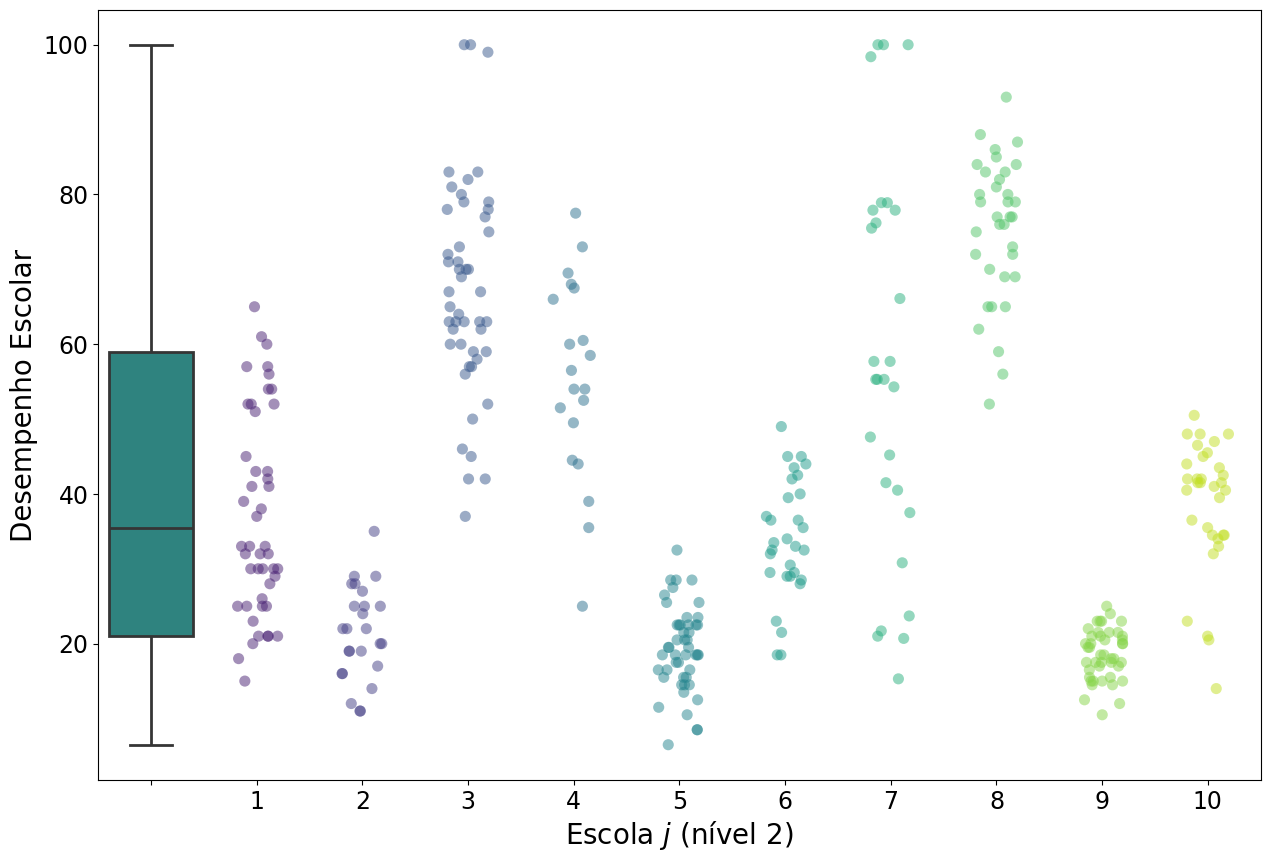

In [14]:
# In[1.6]: Boxplot da variável dependente ('desempenho') por escola
plt.figure(figsize=(15,10))
sns.boxplot(data=df_aluno_escola, y='desempenho',
            linewidth=2, orient='v', palette='viridis')
sns.stripplot(data=df_aluno_escola, x='escola', y='desempenho',
              palette='viridis', jitter=0.2, size=8, alpha=0.5)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xlabel('Escola $j$ (nível 2)', fontsize=20)
plt.tick_params(axis='y', labelsize=17)
plt.tick_params(axis='x', labelsize=17)
plt.show()

Nesta visualização, boxplot único não representa exatamente o comportamento dos dados de cada escola, que varia bastante.

<Figure size 1500x1000 with 0 Axes>

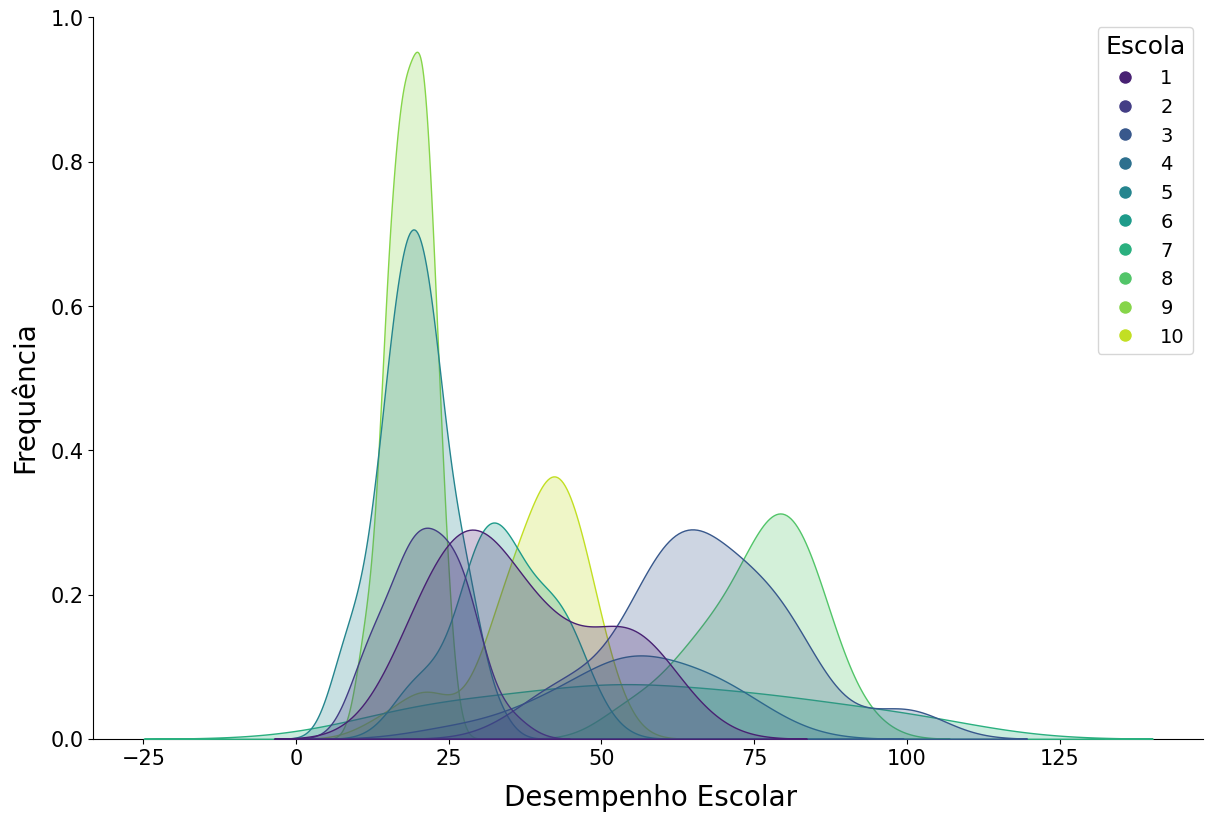

In [15]:
# In[1.7]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho') por escola
escolas = df_aluno_escola['escola'].unique()
colors = sns.color_palette('viridis', len(escolas))

plt.figure(figsize=(15, 10))
g = sns.pairplot(df_aluno_escola[['escola', 'desempenho']], hue='escola',
                 height=8,
                 aspect=1.5, palette=colors)
g._legend.remove()
g.set(xlabel=None)
g.set(ylabel=None)
g.tick_params(axis='both', which='major', labelsize=15)

# Gera a legenda com cores e rótulos das escolas
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=color,
                              markersize=10, label=escola)
                   for escola, color in zip(escolas, colors)]
plt.legend(handles=legend_elements, title='Escola', fontsize=14,
           title_fontsize=18)

# Adiciona os rótulos diretamente na figura
plt.gcf().text(0.5, -0.01, 'Desempenho Escolar', ha='center', fontsize=20)
plt.gcf().text(-0.01, 0.5, 'Frequência', va='center', rotation='vertical',
               fontsize=20)
plt.show()

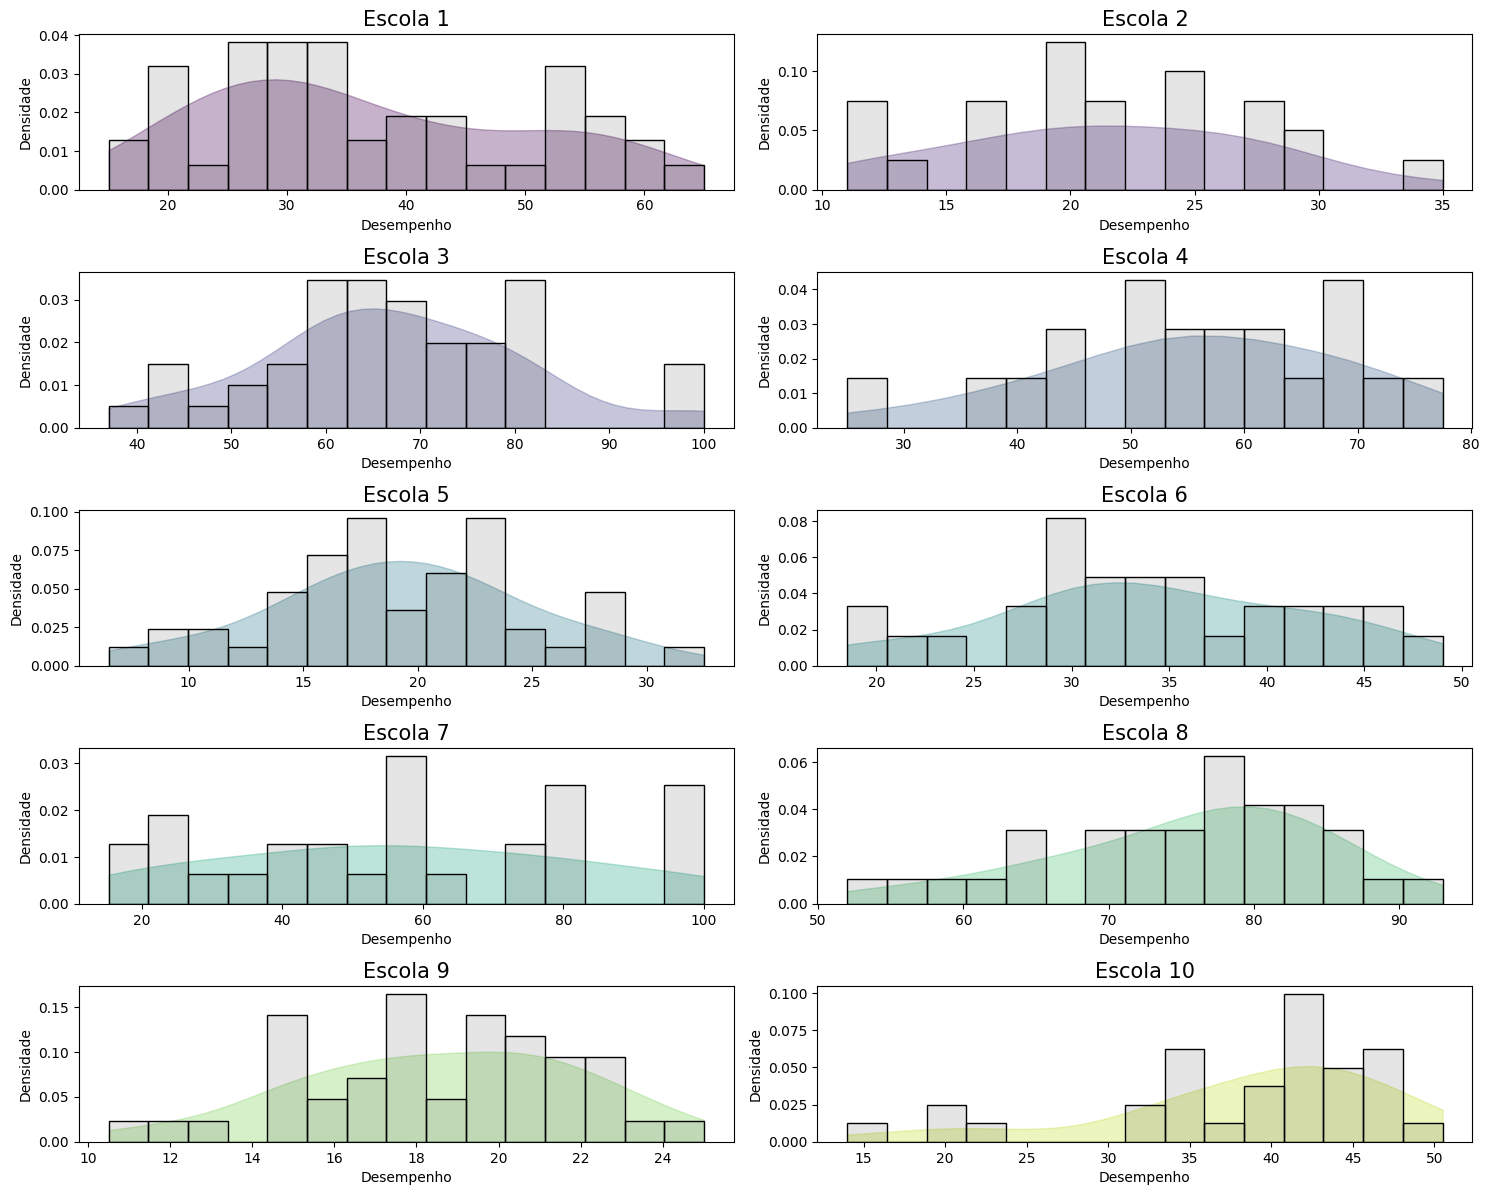

In [16]:
# In[1.8]: Kernel density estimation (KDE) - função densidade de probabilidade
#da variável dependente ('desempenho'), com histograma e por escola separadamente
#(função 'GridSpec' do pacote 'matplotlib.gridspec')
escolas = df_aluno_escola['escola'].unique()

fig = plt.figure(figsize=(15, 14))
gs = GridSpec(len(escolas) // 2 + 1, 2, figure=fig)

for i, escola in enumerate(escolas):
    ax = fig.add_subplot(gs[i])

    # Subset dos dados por escola
    df_escola = df_aluno_escola[df_aluno_escola['escola'] == escola]

    # Densidade dos dados
    densidade = gaussian_kde(df_escola['desempenho'])
    x_vals = np.linspace(min(df_escola['desempenho']),
                         max(df_escola['desempenho']), len(df_escola))
    y_vals = densidade(x_vals)

    # Plotagem da density area
    ax.fill_between(x_vals, y_vals,
                    color=sns.color_palette('viridis',
                                            as_cmap=True)(i/len(escolas)),
                    alpha=0.3)
    
    # Adiciona o histograma
    sns.histplot(df_escola['desempenho'], ax=ax, stat="density", color="black",
                 edgecolor="black", fill=True, 
                 bins=15, alpha=0.1)
    ax.set_title(f'Escola {escola}', fontsize=15)
    ax.set_ylabel('Densidade')
    ax.set_xlabel('Desempenho')

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

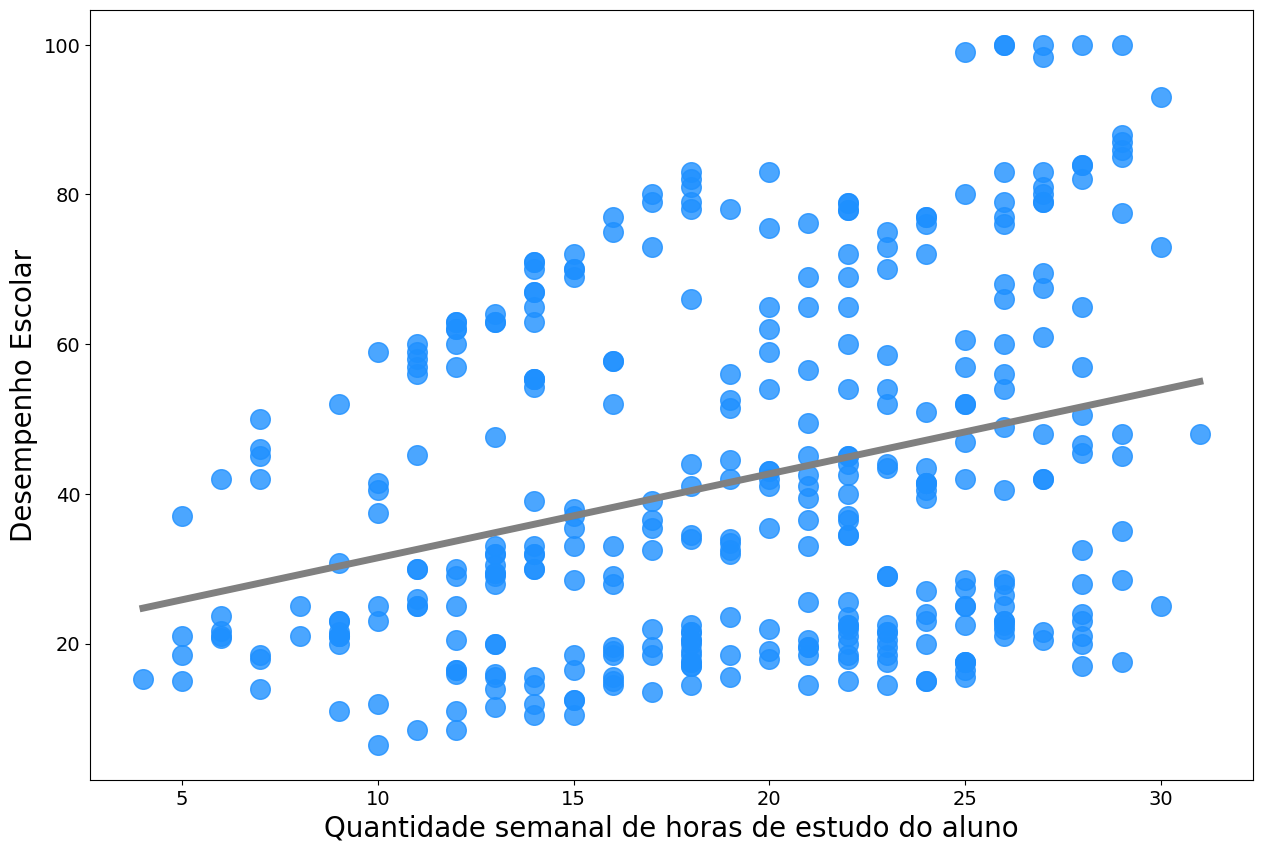

In [17]:
# In[1.9]: Gráfico de desempenho x horas (OLS)
plt.figure(figsize=(15,10))
sns.regplot(data=df_aluno_escola, x='horas', y='desempenho', marker='o', ci=False,
            scatter_kws={"color":'dodgerblue', 'alpha':0.8, 's':200},
            line_kws={"color":'grey', 'linewidth': 5})
plt.xlabel('Quantidade semanal de horas de estudo do aluno', fontsize=20)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show

### Gráfico de desempenho x horas (OLS) por escola separadamente Animação no ambiente Plots

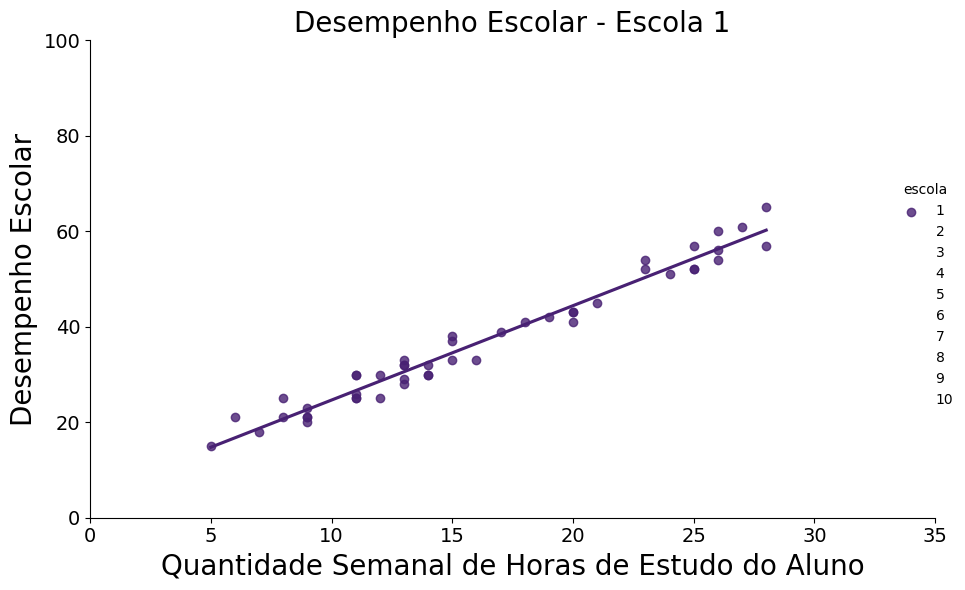

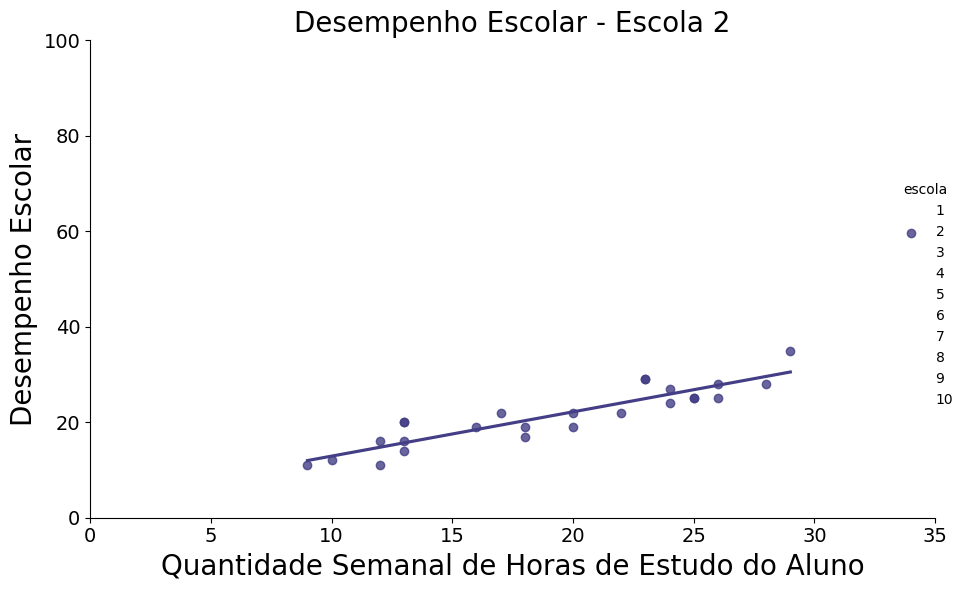

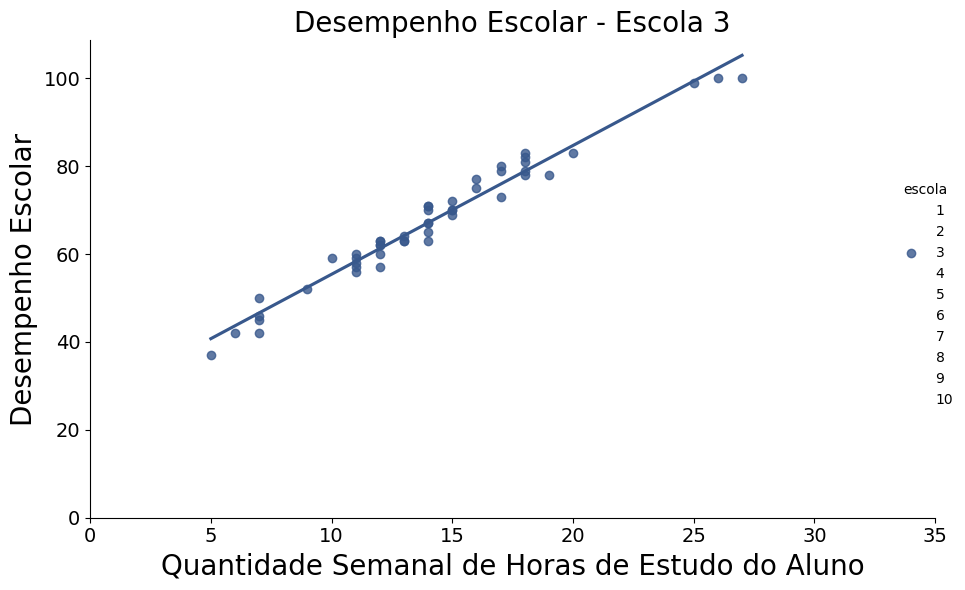

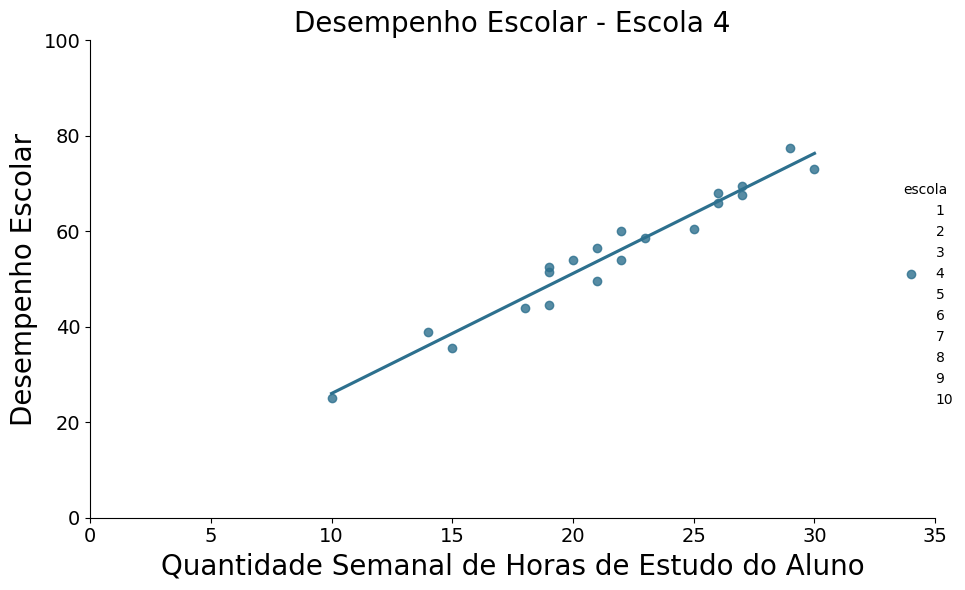

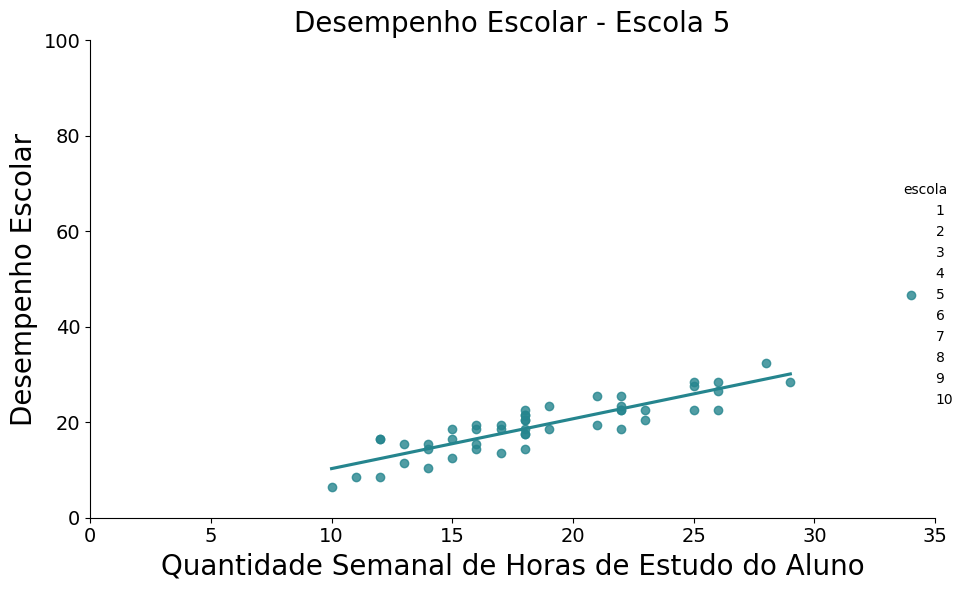

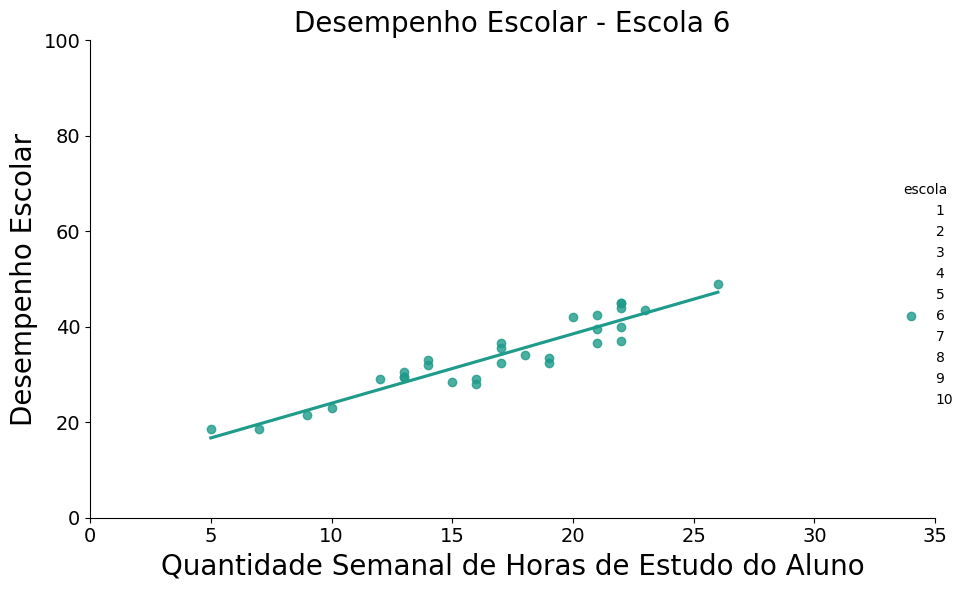

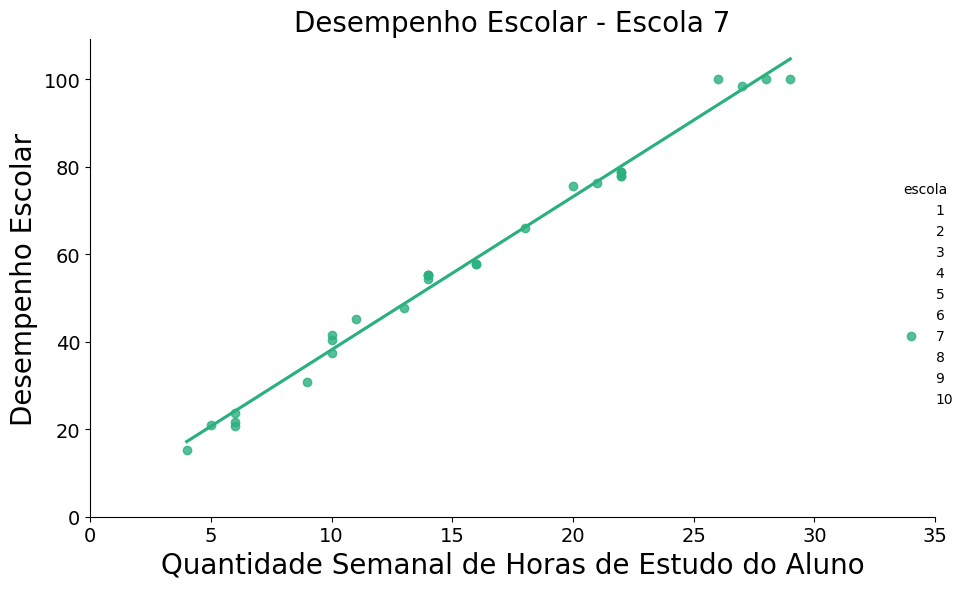

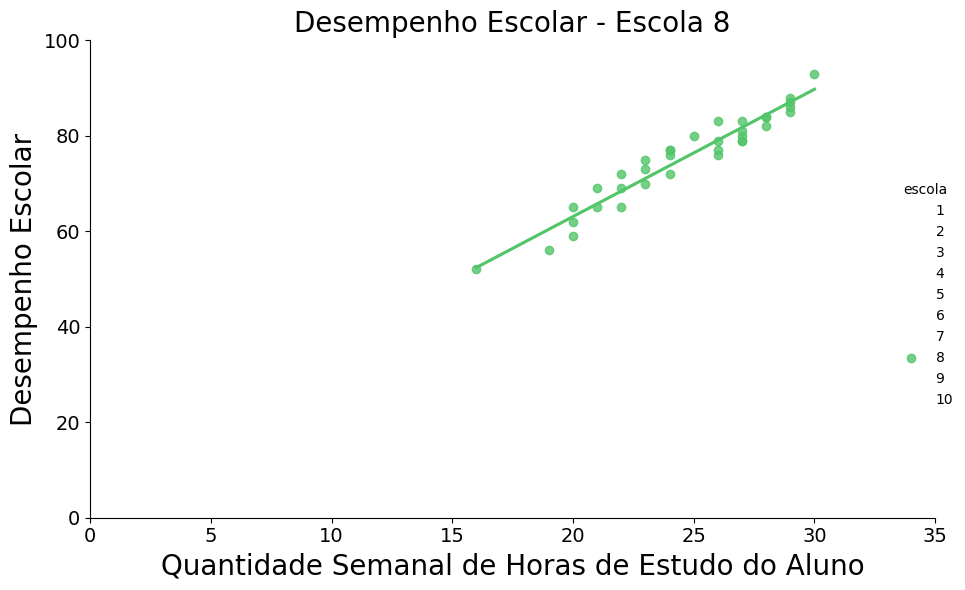

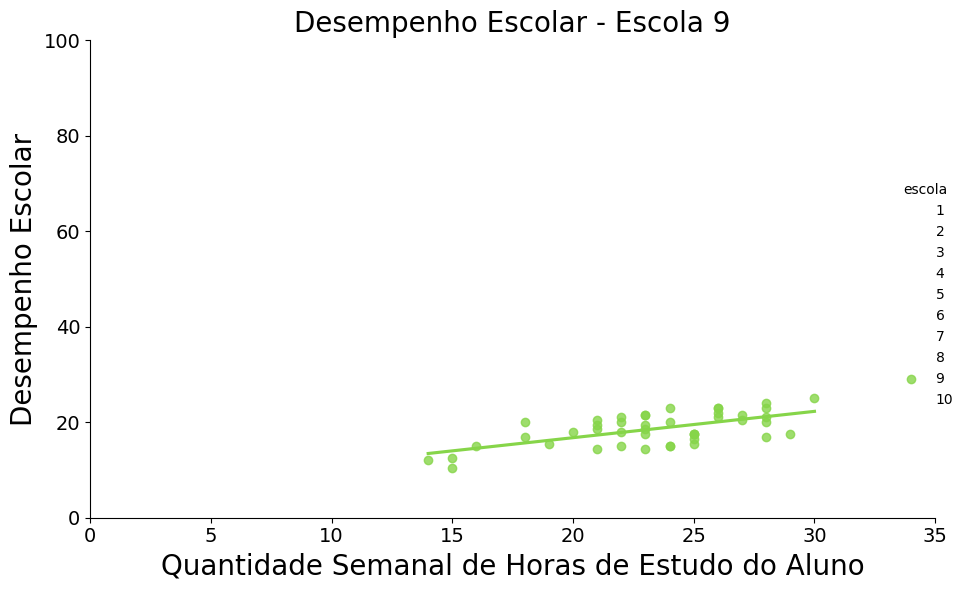

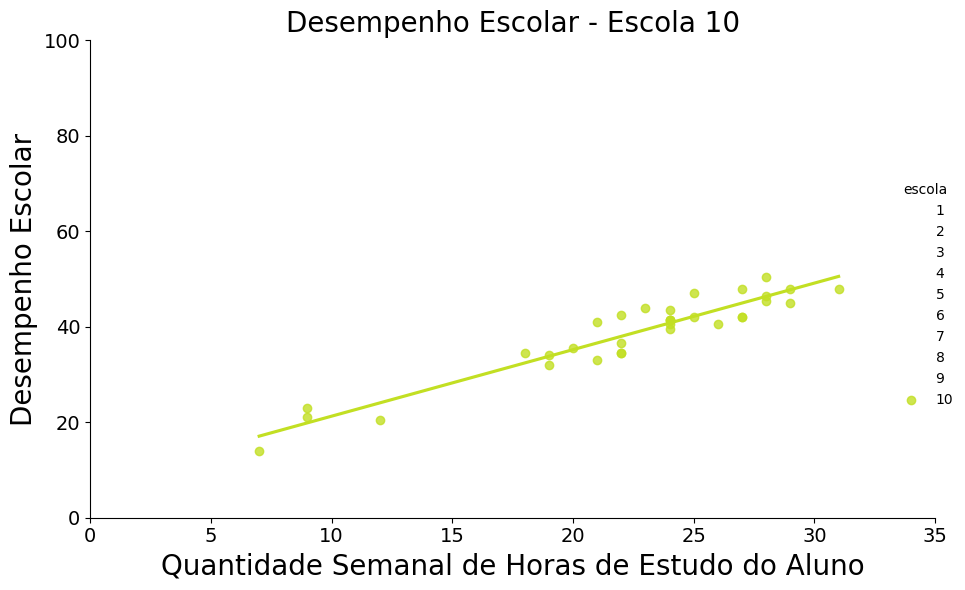

In [18]:
# Obtenção da lista de escolas
escolas = df_aluno_escola['escola'].unique()

# Definição do número de cores na paleta viridis
num_cores = len(escolas)

# Criação do dicionário de mapeamento da escola -> cor
cor_escola = dict(zip(escolas, sns.color_palette('viridis', num_cores)))

# Loop para cada escola
for escola in escolas:
    # Filtro dos dados para determinada escola
    data = df_aluno_escola[df_aluno_escola['escola'] == escola]
    # Criação do lmplot com a cor específica
    sns.lmplot(x='horas', y='desempenho', data=data, hue='escola',
               height=6, aspect=1.5, ci=False, palette=[cor_escola[escola]])
    plt.title(f"Desempenho Escolar - Escola {escola}", fontsize=20)
    plt.xlabel("Quantidade Semanal de Horas de Estudo do Aluno", fontsize = 20)
    plt.ylabel("Desempenho Escolar", fontsize=20)
    plt.yticks(np.arange(0, 101, 20), fontsize=14)
    plt.xticks(np.arange(0, 36, 5), fontsize=14)
    plt.tight_layout()
    # Plotagem da figura
    plt.show()
    # Intervalo de tempo entre os gráficos
    time.sleep(1)

### Gráfico de desempenho x horas (OLS) por escola separadamente Geração de uma Figura GIF

Gerando gráficos:   0%|          | 0/10 [00:00<?, ?escola/s]

/tmp/ipykernel_2709/3928184754.py:31: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(plt_canvas.tostring_rgb(), dtype='uint8')
Gerando gráficos:  10%|█         | 1/10 [00:00<00:03,  2.95escola/s]/tmp/ipykernel_2709/3928184754.py:31: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(plt_canvas.tostring_rgb(), dtype='uint8')
Gerando gráficos:  20%|██        | 2/10 [00:00<00:02,  3.82escola/s]/tmp/ipykernel_2709/3928184754.py:31: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(plt_canvas.tostring_rgb(), dtype='uint8')
Gerando gráficos:  30%|███       | 3/10 [00:00<00:01,  4.25escola/s]/tmp/ipykernel_2709/3928184754.py:31: MatplotlibDepreca

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

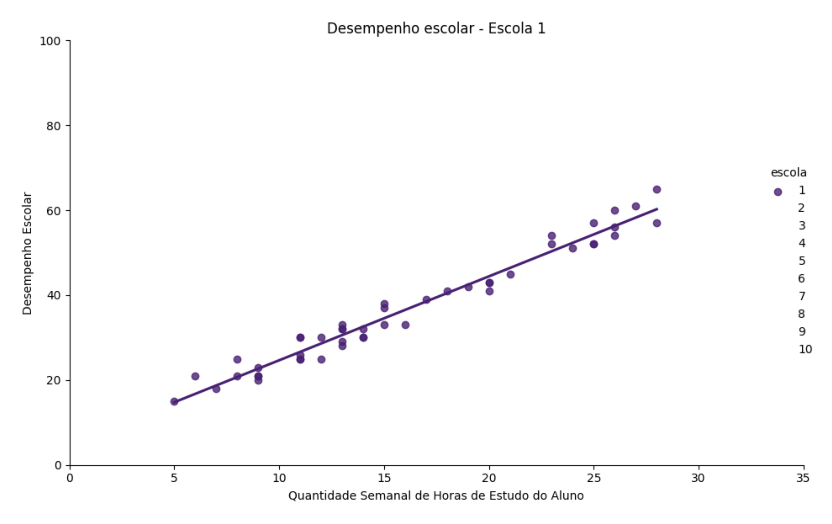

In [19]:
# Obtenção da lista de escolas
escolas = df_aluno_escola['escola'].unique()

# Definição do número de cores na paleta viridis
num_cores = len(escolas)

# Criação do dicionário de mapeamento da escola -> cor
cor_escola = dict(zip(escolas, sns.color_palette('viridis', num_cores)))

# Lista para armazenar os frames dos gráficos
frames = []

# Loop para cada escola com 'tqdm' para mostrar o progresso
for escola in tqdm(escolas, desc="Gerando gráficos", unit="escola"):
    # Filtro dos dados para determinada escola
    data = df_aluno_escola[df_aluno_escola['escola'] == escola]

    # Criação do lmplot com a cor específica
    sns.lmplot(x='horas', y='desempenho', data=data, hue='escola',
               height=6, aspect=1.5, ci=False, palette=[cor_escola[escola]])
    plt.title(f"Desempenho escolar - Escola {escola}")
    plt.xlabel("Quantidade Semanal de Horas de Estudo do Aluno")
    plt.ylabel("Desempenho Escolar")
    plt.yticks(np.arange(0, 101, 20))
    plt.xticks(np.arange(0, 36, 5))
    plt.tight_layout()
    
    # Converte o gráfico em um array de imagens
    plt_canvas = plt.get_current_fig_manager().canvas
    plt_canvas.draw()
    image = np.frombuffer(plt_canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(plt_canvas.get_width_height()[::-1] + (3,))

    # Anexa o array de imagens à lista de quadros (frames)
    frames.append(image)

    # Limpa o gráfico para a próxima iteração
    plt.clf()

# Salva os quadros (frames) como um GIF
imageio.mimsave('graficos_escolas.gif', frames, fps=1)

# Mostra o GIF
plt.imshow(frames[0])
plt.axis('off')
plt.show()

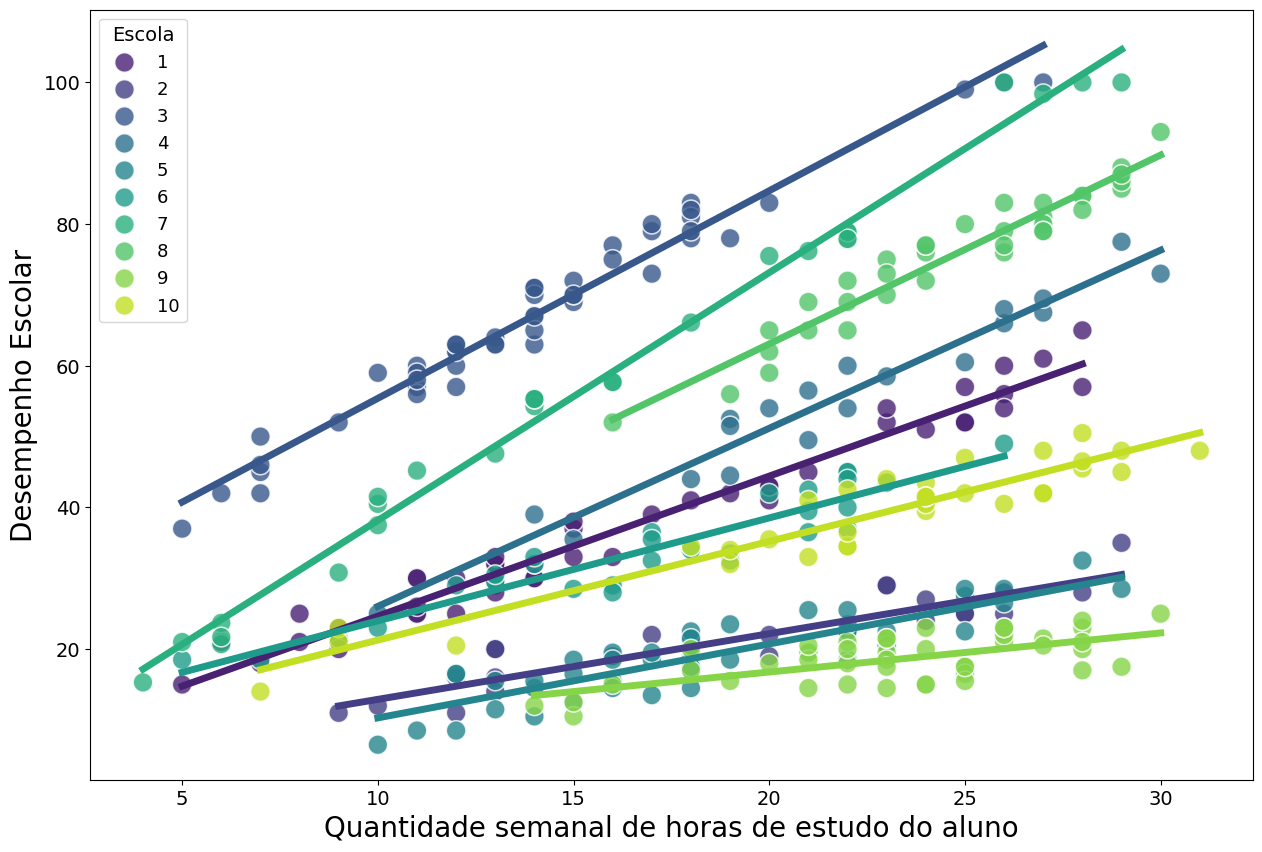

In [20]:
# In[1.12]: Gráfico de desempenho escolar em função da variável 'horas'
# Variação entre estudantes de uma mesma escola e entre escolas diferentes
# Visualização do contexto!
palette = sns.color_palette('viridis',
                            len(df_aluno_escola['escola'].unique()))

plt.figure(figsize=(15,10))
sns.scatterplot(data=df_aluno_escola, x='horas', y='desempenho', hue='escola',
                palette=palette, s=200, alpha=0.8, edgecolor='w')

for escola in df_aluno_escola['escola'].cat.categories:
    subset = df_aluno_escola[df_aluno_escola['escola'] == escola]
    sns.regplot(data=subset, x='horas', y='desempenho', scatter=False, ci=False,
                line_kws={"color": palette[df_aluno_escola['escola'].cat.categories.get_loc(escola)], 'linewidth': 5})

plt.xlabel('Quantidade semanal de horas de estudo do aluno', fontsize=20)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Escola', title_fontsize='14', fontsize='13', loc='upper left')
plt.show()

NOTE QUE A PERSPECTIVA MULTINÍVEL NATURALMENTE CONSIDERA O *COMPORTAMENTO HETEROCEDÁSTICO* NOS DADOS!

### ESTIMAÇÃO DO MODELO NULO HLM2
Sem Efeitos Fixos ou Aleatórios

In [21]:
# Estimação do modelo nulo (função 'MixedLM' do pacote 'statsmodels')
modelo_nulo_hlm2 = sm.MixedLM.from_formula(formula='desempenho ~ 1',
                                           groups='escola',
                                           re_formula='1',
                                           data=df_aluno_escola).fit()

# Parâmetros do 'modelo_nulo_hlm2'
modelo_nulo_hlm2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: desempenho
No. Observations: 358     Method:             REML      
No. Groups:       10      Scale:              142.9242  
Min. group size:  20      Log-Likelihood:     -1416.0074
Max. group size:  48      Converged:          Yes       
Mean group size:  35.8                                  
--------------------------------------------------------
               Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      42.387    6.468 6.553 0.000 29.709 55.065
escola Var    414.067   16.695                          
========================================================

"""

In [22]:
414.067 / 16.695

24.801856843366277

In [23]:
# In[1.14]: Análise da significância estatística dos efeitos aleatórios de
#intercepto
teste = float(modelo_nulo_hlm2.cov_re.iloc[0, 0]) /\
    float(pd.DataFrame(modelo_nulo_hlm2.summary().tables[1]).iloc[1, 1])

p_value = 2 * (1 - stats.norm.cdf(abs(teste)))

print(f"Estatística z para a Significância dos Efeitos Aleatórios: {teste:.3f}")
print(f"P-valor: {p_value:.3f}")

if p_value >= 0.05:
    print("Ausência de significância estatística dos efeitos aleatórios ao nível de confiança de 95%.")
else:
    print("Efeitos aleatórios contextuais significantes ao nível de confiança de 95%.")

Estatística z para a Significância dos Efeitos Aleatórios: 24.802
P-valor: 0.000
Efeitos aleatórios contextuais significantes ao nível de confiança de 95%.


Isso aqui já basta para descartarmos a OLS

### COMPARAÇÃO DO HLM2 NULO COM UM OLS NULO

In [24]:
# Estimação de um modelo OLS nulo
modelo_ols_nulo = sm.OLS.from_formula(formula='desempenho ~ 1',
                                      data=df_aluno_escola).fit()

# Parâmetros do 'modelo_ols_nulo'
modelo_ols_nulo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 03 Oct 2024   Prob (F-statistic):                nan
Time:                        09:17:22   Log-Likelihood:                -1633.5
No. Observations:                 358   AIC:                             3269.
Df Residuals:                     357   BIC:                             3273.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.5542      1.228     33.852      0.000      39.140      43.968
==============================================================================
Omnibus:                       38.443   Durbin-Watson:                   0.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.903
Skew:                           0.626   Prob(JB):                     1.95e-07
Kurtosis:                       2.291   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

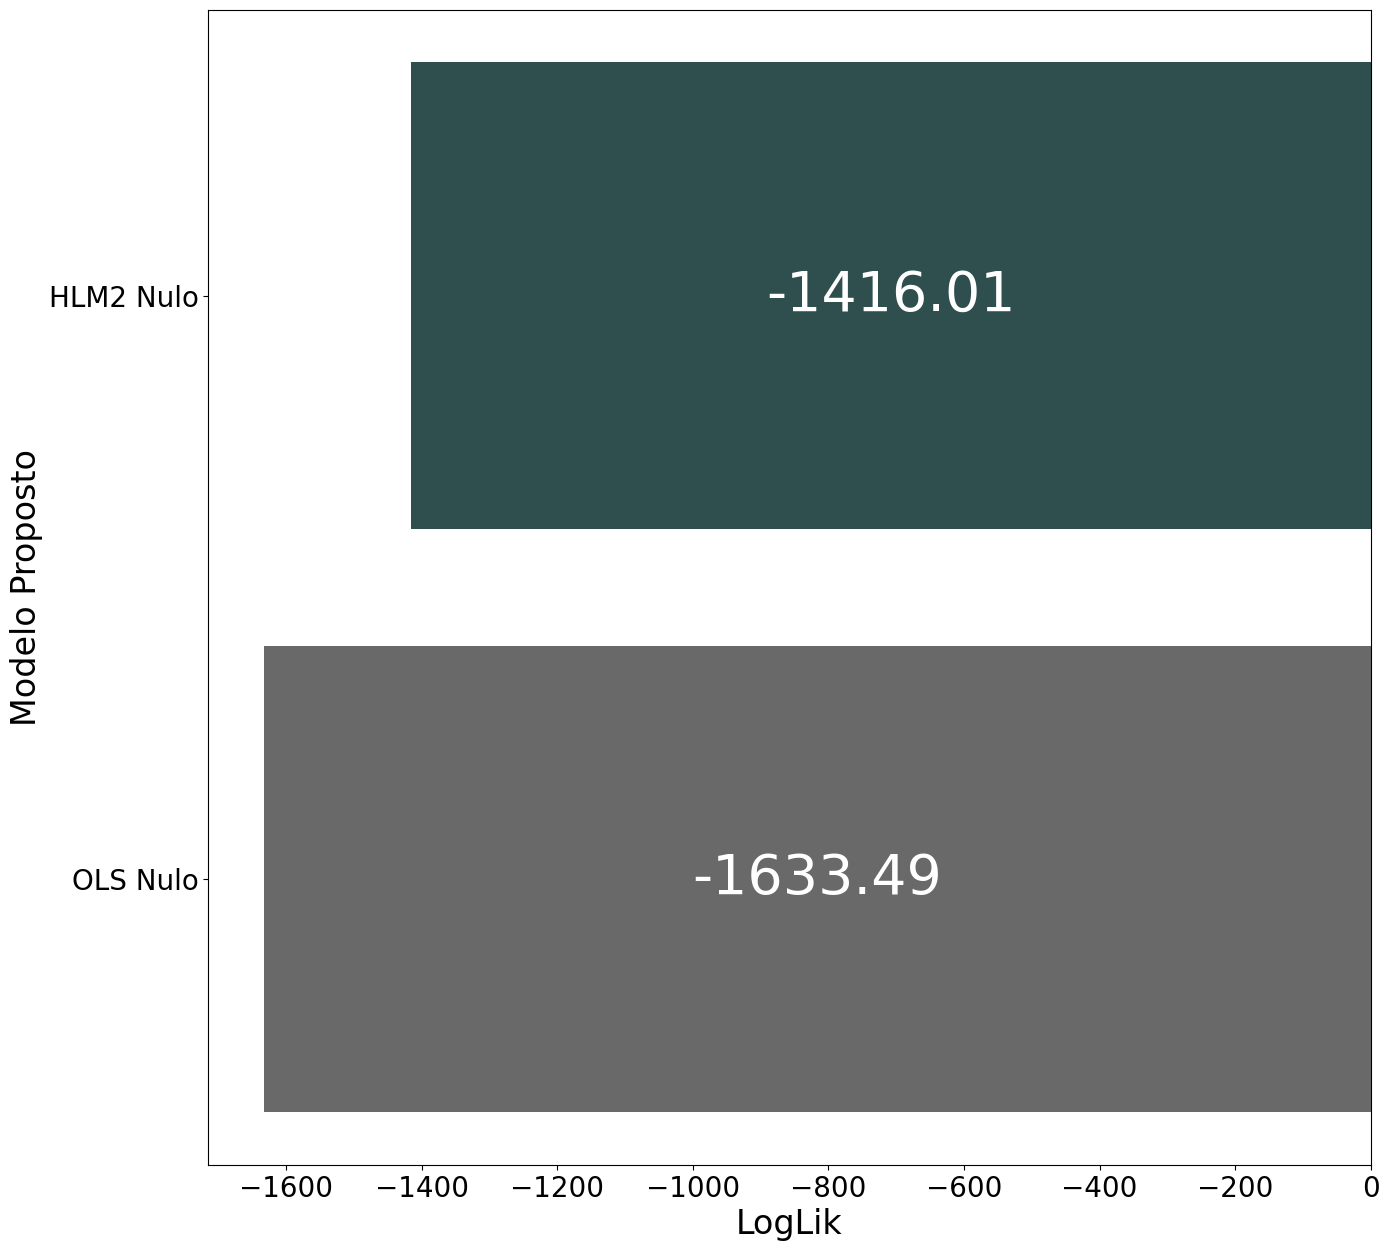

In [25]:
# In[1.16]: Gráfico para comparação visual dos logLiks dos modelos estimados
#até o momento
df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM2 Nulo'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()


In [26]:
# In[1.17]: Teste de razão de verossimilhança entre o 'modelo_nulo_hlm2' e o
#'modelo_ols_nulo'
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llf
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

In [27]:
# In[1.18]: Teste de de razão de verossimilhança para comparar as estimações
#dos 'modelo_ols_nulo' e 'modelo_nulo_hlm2'
lrtest([modelo_ols_nulo, modelo_nulo_hlm2])

Likelihood Ratio Test:
-2.(LL0-LLm): 434.96
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


### ESTIMAÇÃO DO MODELO COM INTERCEPTOS E INCLINAÇÕES ALEATÓRIOS HLM2

#### Estimação do modelo com interceptos e inclinações aleatórios

In [28]:
modelo_intercept_inclin_hlm2 = sm.MixedLM.from_formula(formula='desempenho ~ horas',
                                                       groups='escola',
                                                       re_formula='horas',
                                                       data=df_aluno_escola).fit()

# Parâmetros do 'modelo_intercept_inclin_hlm2'
modelo_intercept_inclin_hlm2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:              MixedLM  Dependent Variable:  desempenho
No. Observations:   358      Method:              REML      
No. Groups:         10       Scale:               7.0497    
Min. group size:    20       Log-Likelihood:      -906.8028 
Max. group size:    48       Converged:           Yes       
Mean group size:    35.8                                    
------------------------------------------------------------
                   Coef.  Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           7.121    2.426 2.935 0.003  2.366 11.875
horas               1.895    0.308 6.158 0.000  1.292  2.498
escola Var         55.078   10.278                          
escola x horas Cov  2.568    0.986                          
horas Var           0.938    0.170                          
============================================================

"""

$𝑑𝑒𝑠𝑒𝑚𝑝𝑒𝑛ℎ𝑜_{𝑖𝑗} = 𝛾_{00} + 𝛾_{10}.horas_{𝑖𝑗} + 𝜈_{0𝑗} + 𝜈_{1𝑗}.ℎ𝑜𝑟𝑎𝑠_{𝑖𝑗} + 𝜀𝑖𝑗$

- Scale: 7.0497: variância dos valores aleatórios idiossincráticos | var($ϵ_{ij}$)
- Intercept: $𝛾_{00}$
- horas: $𝛾_{10}$
- escola Var: var($𝜈_{0𝑗}$)
- horas Var: var($𝜈_{1𝑗}$)

In [29]:
# In[1.20]: Análise da significância estatística dos efeitos aleatórios de
#intercepto
teste = float(modelo_intercept_inclin_hlm2.cov_re.iloc[0, 0]) /\
    float(pd.DataFrame(modelo_intercept_inclin_hlm2.summary().tables[1]).iloc[2, 1])

p_value = 2 * (1 - stats.norm.cdf(abs(teste)))

print(f"Estatística z para a Significância dos Efeitos Aleatórios: {teste:.3f}")
print(f"P-valor: {p_value:.3f}")

if p_value >= 0.05:
    print("Ausência de significância estatística dos efeitos aleatórios ao nível de confiança de 95%.")
else:
    print("Efeitos aleatórios contextuais significantes ao nível de confiança de 95%.")

Estatística z para a Significância dos Efeitos Aleatórios: 5.359
P-valor: 0.000
Efeitos aleatórios contextuais significantes ao nível de confiança de 95%.


In [30]:
# In[1.21]: Análise da significância estatística dos efeitos aleatórios de
#inclinação
teste = float(modelo_intercept_inclin_hlm2.cov_re.iloc[1, 1]) /\
    float(pd.DataFrame(modelo_intercept_inclin_hlm2.summary().tables[1]).iloc[4, 1])

p_value = 2 * (1 - stats.norm.cdf(abs(teste)))

print(f"Estatística z para a Significância dos Efeitos Aleatórios: {teste:.3f}")
print(f"P-valor: {p_value:.3f}")

if p_value >= 0.05:
    print("Ausência de significância estatística dos efeitos aleatórios ao nível de confiança de 95%.")
else:
    print("Efeitos aleatórios contextuais significantes ao nível de confiança de 95%.")

Estatística z para a Significância dos Efeitos Aleatórios: 5.518
P-valor: 0.000
Efeitos aleatórios contextuais significantes ao nível de confiança de 95%.


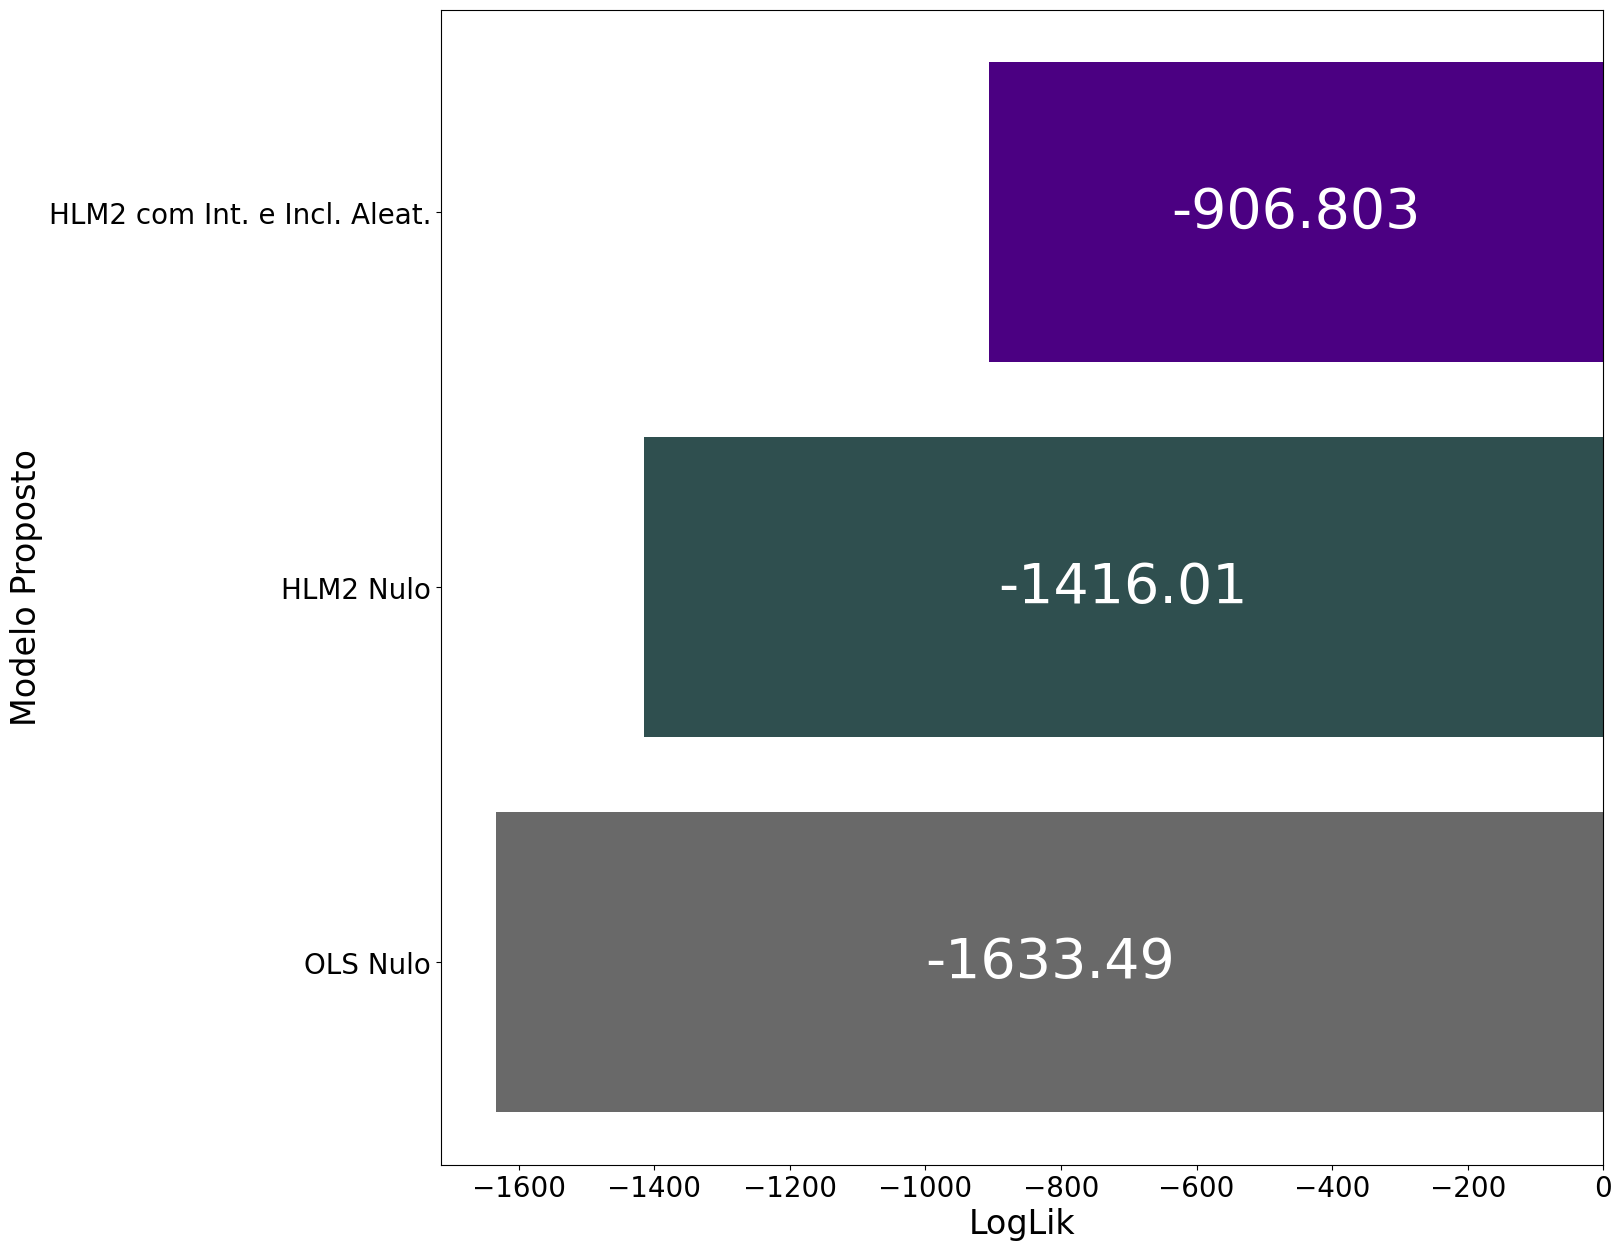

In [31]:
# In[1.22]: Gráfico para comparação visual dos logLiks dos modelos estimados
#até o momento
df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM2 Nulo',
                                 'HLM2 com Int. e Incl. Aleat.'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm2.llf,
                                modelo_intercept_inclin_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray','indigo']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

O que contribuiu para este ganho?
- a significância estatística dos efeitos aleatórios de inclinação
- a inserção da variável 'horas' no componente de efeito fixo

In [32]:
# In[1.23]: Teste de razão de verossimilhança entre o 'modelo_nulo_hlm2' e o
#'modelo_intercept_inclin_hlm2'
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llf
    llk_2 = modelo_1.llf
    
    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 2) # 2 graus de liberdade
    
    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

- 2 graus de liberdade? pois passamos de 3 para 5 parâmetros

In [33]:
# In[1.24]: Teste de de razão de verossimilhança para comparar as estimações
#dos 'modelo_nulo_hlm2' e 'modelo_intercept_inclin_hlm2'
lrtest([modelo_nulo_hlm2, modelo_intercept_inclin_hlm2])

Likelihood Ratio Test:
-2.(LL0-LLm): 1018.41
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


####  ESTIMAÇÃO DO MODELO FINAL COM INTERCEPTOS E INCLINAÇÕES ALEATÓRIOS HLM2

$𝑑𝑒𝑠𝑒𝑚𝑝𝑒𝑛ℎ𝑜_{𝑖𝑗} = 𝛾_{00} + 𝛾_{10}.horas_{𝑖𝑗} + 𝛾_{01}.texp_{𝑗} + γ_{11}.texp_{𝑗}.ℎ𝑜𝑟𝑎𝑠_{𝑖𝑗} + 𝜈_{0𝑗} + 𝜈_{1𝑗}.ℎ𝑜𝑟𝑎𝑠_{𝑖𝑗} + 𝜀𝑖𝑗$

In [34]:
# Estimação do modelo final com interceptos e inclinações aleatórios
modelo_final_hlm2 = sm.MixedLM.from_formula(formula='desempenho ~ horas + texp +\
                                            horas:texp', #horas x texp
                                            groups='escola',
                                            re_formula='horas',
                                            data=df_aluno_escola).fit()

# Parâmetros do modelo 'modelo_final_hlm2'
modelo_final_hlm2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:               MixedLM  Dependent Variable:  desempenho
No. Observations:    358      Method:              REML      
No. Groups:          10       Scale:               7.0443    
Min. group size:     20       Log-Likelihood:      -894.5684 
Max. group size:     48       Converged:           Yes       
Mean group size:     35.8                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -0.850    2.999 -0.283 0.777 -6.727  5.028
horas               0.713    0.321  2.225 0.026  0.085  1.342
texp                1.585    0.487  3.256 0.001  0.631  2.540
horas:texp          0.232    0.053  4.405 0.000  0.129  0.335
escola Var         24.345    5.167                           
escola x horas Cov -2.354    0.514                           
horas Var           0.305    0.059                           
=============================================================

"""

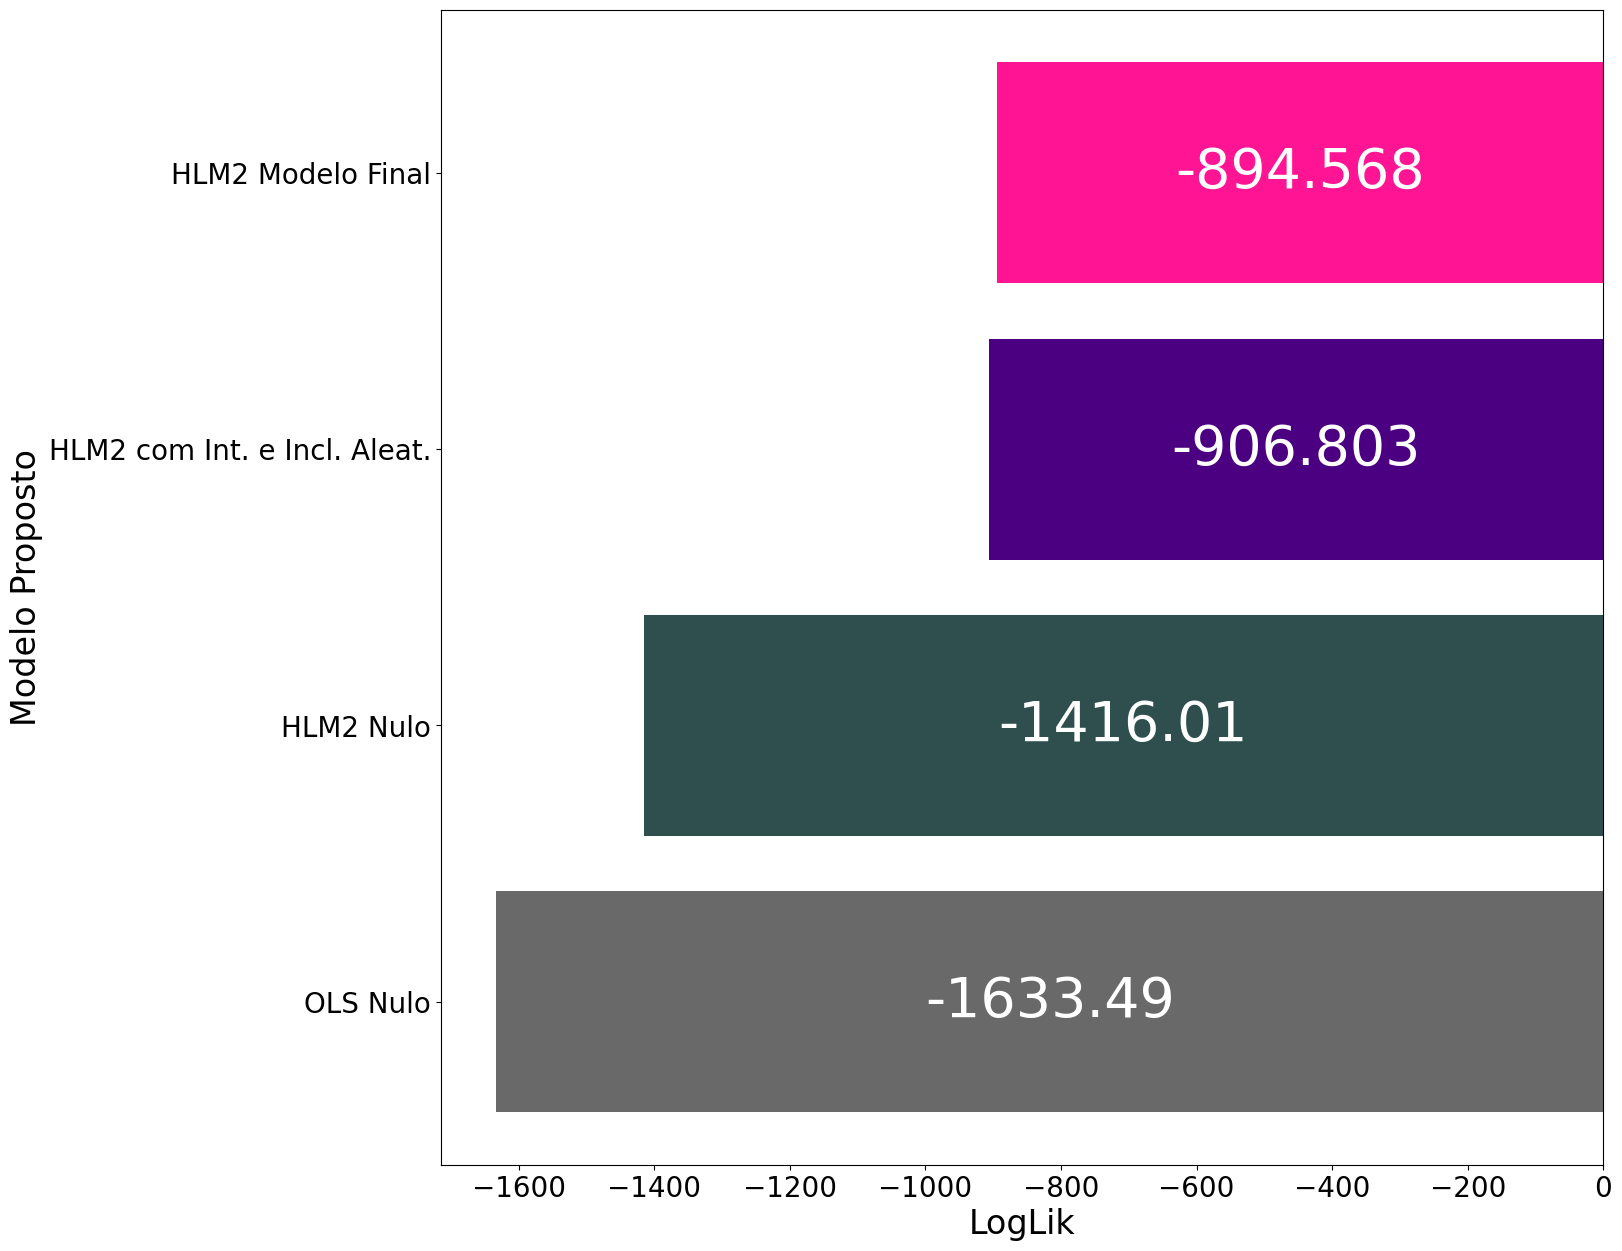

In [35]:
# In[1.26]: Gráfico para comparação visual dos logLiks dos modelos estimados
#até o momento
df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM2 Nulo',
                                 'HLM2 com Int. e Incl. Aleat.',
                                 'HLM2 Modelo Final'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm2.llf,
                                modelo_intercept_inclin_hlm2.llf,
                                modelo_final_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray','indigo','deeppink']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

In [36]:
# In[1.27]: Teste de de razão de verossimilhança para comparar as estimações
#dos 'modelo_intercept_inclin_hlm2' e 'modelo_final_hlm2'
lrtest([modelo_intercept_inclin_hlm2, modelo_final_hlm2])

Likelihood Ratio Test:
-2.(LL0-LLm): 24.47
p-value: 0.000

==================Result======================== 

H1: Different models, favoring the one with the highest Log-Likelihood


In [37]:
# In[1.28]: Visualização dos interceptos e inclinações aleatórios por escola,
#para o 'modelo_final_hlm2'
pd.DataFrame(modelo_final_hlm2.random_effects)

,1,2,3,4,5,6,7,8,9,10
escola,-0.211364,1.291495,6.090772,-5.245506,-1.695358,3.864292,-8.270892,-1.363471,3.705674,1.834358
horas,0.438811,-0.278181,-0.779130,0.450368,-0.139678,0.005096,0.909171,0.217166,-0.607100,-0.216522


In [38]:
# In[1.29]: Melhor visualização dos interceptos e inclinações aleatórios por
#escola, para o 'modelo_final_hlm2'
efeitos_aleatorios = pd.DataFrame(modelo_final_hlm2.random_effects).T
efeitos_aleatorios = efeitos_aleatorios.rename(columns = {'escola':'v0j'})
efeitos_aleatorios = efeitos_aleatorios.rename(columns = {'horas':'v1j'})
efeitos_aleatorios = efeitos_aleatorios.reset_index().rename(columns={'index': 'escola'})
efeitos_aleatorios.head()

,escola,v0j,v1j
0,1,-0.211364,0.438811
1,2,1.291495,-0.278181
2,3,6.090772,-0.779130
3,4,-5.245506,0.450368
4,5,-1.695358,-0.139678


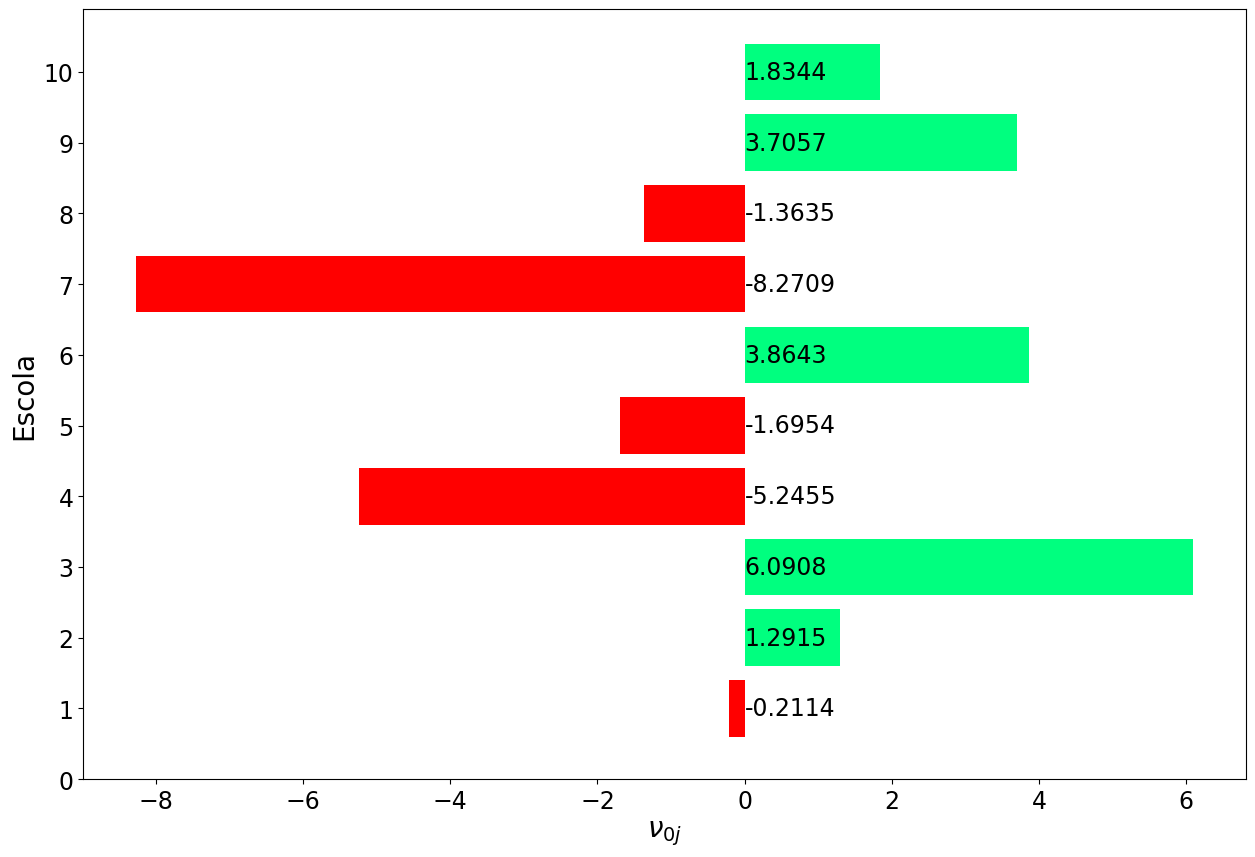

In [39]:
# In[1.30]: Gráfico para visualização do comportamento dos valores de v0j,
#ou seja, dos interceptos aleatórios por escola
# Para a construção deste gráfico, é necessário, momentaneamente, transformar a
#variável 'escola' para o formato 'int'
df_aluno_escola['escola'] = df_aluno_escola['escola'].astype('int')

colors = ['springgreen' if x>0 else 'red' for x in efeitos_aleatorios['v0j']]

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(0, point['y'], str(round(point['x'],4)), fontsize=17,
                verticalalignment='center')

plt.figure(figsize=(15,10))
plt.barh(efeitos_aleatorios['escola'], efeitos_aleatorios['v0j'], color=colors)

label_point(x = efeitos_aleatorios['v0j'],
            y = efeitos_aleatorios['escola'],
            val = efeitos_aleatorios['v0j'],
            ax = plt.gca()) 
plt.ylabel('Escola', fontsize=20)
plt.xlabel(r'$\nu_{0j}$', fontsize=20)
plt.tick_params(axis='x', labelsize=17)
plt.tick_params(axis='y', labelsize=17)
plt.yticks(np.arange(0, 11, 1))
plt.show()

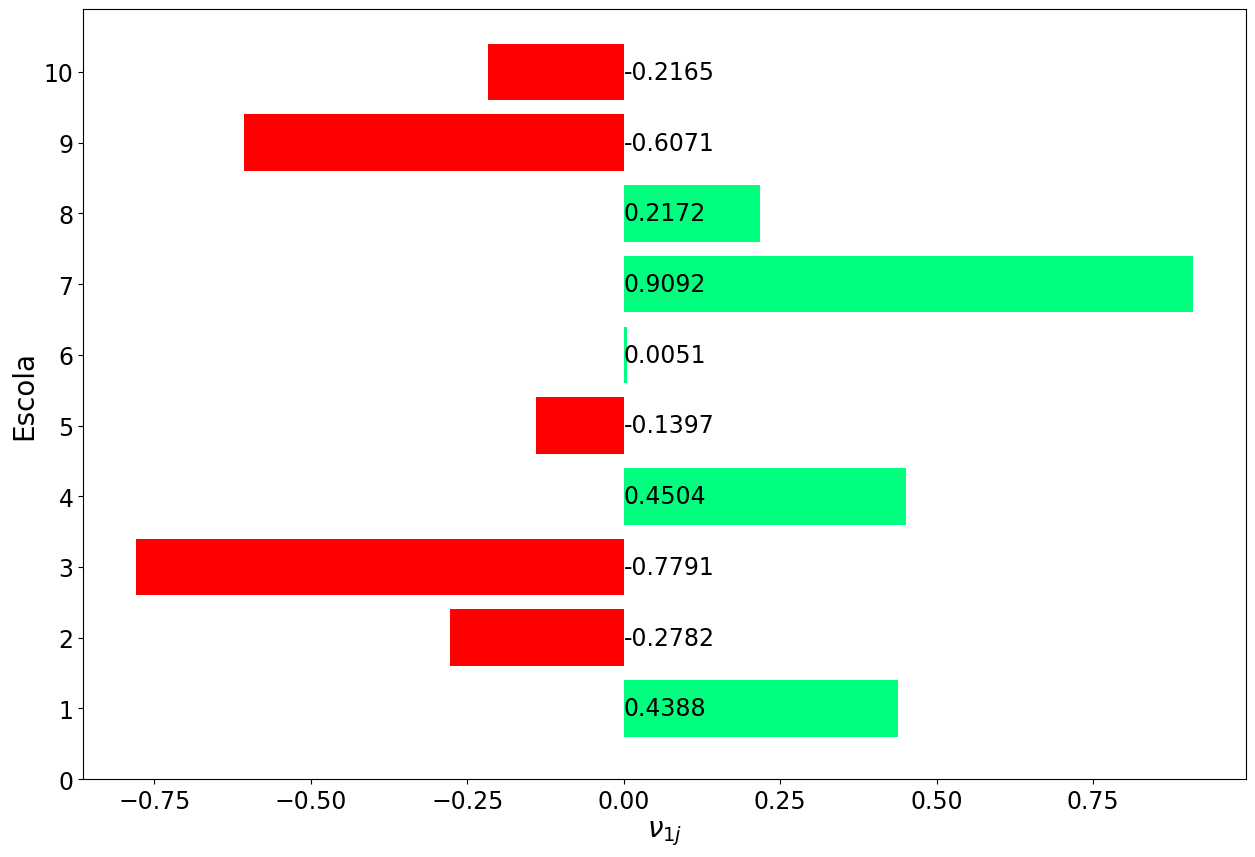

In [40]:
# In[1.31]: Gráfico para visualização do comportamento dos valores de v1j,
#ou seja, das inclinações aleatórias por escola
colors = ['springgreen' if x>0 else 'red' for x in efeitos_aleatorios['v1j']]
 
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(0, point['y'], str(round(point['x'],4)), fontsize=17,
                verticalalignment='center')

plt.figure(figsize=(15,10))
plt.barh(efeitos_aleatorios['escola'], efeitos_aleatorios['v1j'], color=colors)

label_point(x = efeitos_aleatorios['v1j'],
            y = efeitos_aleatorios['escola'],
            val = efeitos_aleatorios['v1j'],
            ax = plt.gca()) 
plt.ylabel('Escola', fontsize=20)
plt.xlabel(r'$\nu_{1j}$', fontsize=20)
plt.tick_params(axis='x', labelsize=17)
plt.tick_params(axis='y', labelsize=17)
plt.yticks(np.arange(0, 11, 1))
plt.show()

### Previsões - fitted.fixed

In [42]:
# In[1.32]: Tornando novamente a variável 'escola' categórica
df_aluno_escola['escola'] = df_aluno_escola['escola'].astype('category')

# In[1.33]: Visualização dos fitted values do 'modelo_final_hlm2', por
#estudante e por escola
df_aluno_escola['fitted.fixed'] = pd.DataFrame(modelo_final_hlm2.predict())
df_aluno_escola['fitted.completo'] = modelo_final_hlm2.fittedvalues
df_aluno_escola['eij'] = modelo_final_hlm2.resid
df_aluno_escola.head()

,estudante,escola,desempenho,horas,texp,fitted.fixed,fitted.completo,eij
0,1,1,25.0,11,3.6,21.885819,26.501371,-1.501371
1,2,1,52.0,23,3.6,40.462363,50.343641,1.656359
2,3,1,52.0,25,3.6,43.558453,54.317353,-2.317353
3,4,1,30.0,14,3.6,26.529955,32.461938,-2.461938
4,5,1,51.0,24,3.6,42.010408,52.330497,-1.330497


### Elaboração de previsões para o 'modelo_final_hlm2'
Quais os valores previstos de desempenho escolar, para dado
#aluno que estuda na escola "1", sabendo-se que estuda 11 horas por semana e que a escola oferece tempo médio de experiência de seus professores igual a 3,6 anos?

In [43]:
# In[1.34]
# O resultado obtido por meio da função 'predict' só considera efeitos fixos.
# Criação do objeto 'resultado_fixo' apenas com o efeito fixo
resultado_fixo = modelo_final_hlm2.predict(pd.DataFrame({'horas':[11],
                                                         'texp':[3.6],
                                                         'escola':['1']}))
resultado_fixo

0    21.885819
dtype: float64

A função 'predict' não considera os efeitos aleatórios de intercepto ou de
inclinação por 'escola'. Neste sentido, precisamos adicioná-los a partir dos parâmetros do 'modelo_final_hlm2', conforme segue.

In [44]:
# In[1.35]: Predição completa para o enunciado anterior, com efeitos fixos e
#aleatórios para a escola 1
resultado_completo = resultado_fixo + efeitos_aleatorios['v0j'][0] +\
    efeitos_aleatorios['v1j'][0]*11

resultado_completo

0    26.501371
dtype: float64

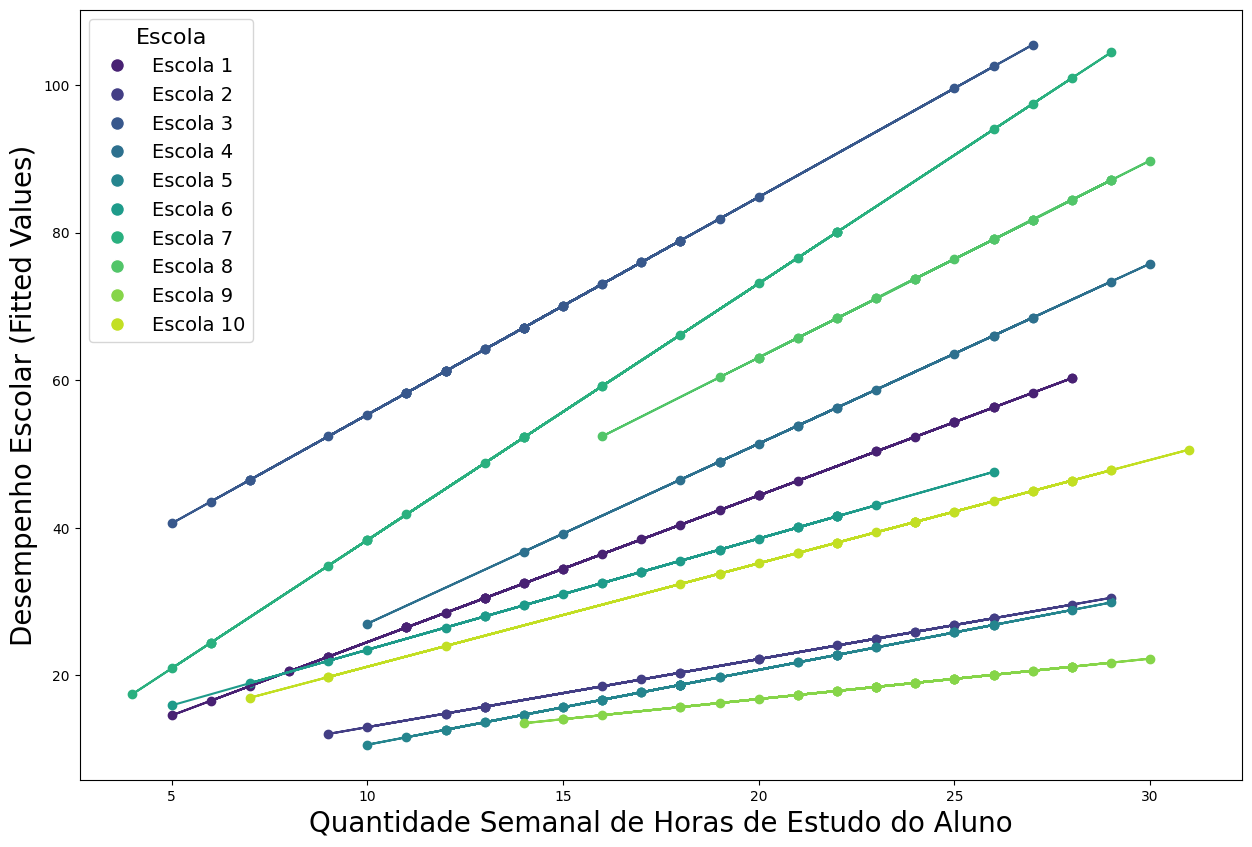

In [45]:
# In[1.36]: Gráfico com valores previstos do desempenho escolar em função da
#variável 'horas' para o 'modelo_final_hlm2'
plt.figure(figsize=(15, 10))

escolas = df_aluno_escola['escola'].unique()
colors = sns.color_palette('viridis', len(escolas))

for escola in escolas:
    plt.plot(df_aluno_escola[df_aluno_escola['escola'] == escola].horas,
             df_aluno_escola[df_aluno_escola['escola'] == escola]['fitted.completo'],
             color=colors[escola-1])
    plt.scatter(df_aluno_escola[df_aluno_escola['escola'] == escola].horas,
                df_aluno_escola[df_aluno_escola['escola'] == escola]['fitted.completo'],
                color=colors[escola-1])

plt.ylabel('Desempenho Escolar (Fitted Values)', fontsize=20)
plt.xlabel('Quantidade Semanal de Horas de Estudo do Aluno', fontsize=20)

# Criação da legenda com cores e rótulos das escolas
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
                              markersize=10, label=f'Escola {escola}')
                   for escola, color in zip(escolas, colors)]
plt.legend(handles=legend_elements, title='Escola', fontsize=14, title_fontsize=16)
plt.show()

### COMPARAÇÃO COM UM MODELO OLS

In [46]:
# Estimação de um modelo OLS para fins de comparação
modelo_ols = sm.OLS.from_formula('desempenho ~ horas + texp', df_aluno_escola).fit()

# Parâmetros do modelo
modelo_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     827.1
Date:                Thu, 03 Oct 2024   Prob (F-statistic):          2.38e-134
Time:                        10:09:06   Log-Likelihood:                -1323.2
No. Observations:                 358   AIC:                             2652.
Df Residuals:                     355   BIC:                             2664.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -23.3983      1.989    -11.761      0.000     -27.311     -19.486
horas          1.9100      0.084     22.758      0.000       1.745       2.075
texp           5.5545      0.145     38.268      0.000       5.269       5.840
==============================================================================
Omnibus:                        8.245   Durbin-Watson:                   0.719
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                5.073
Skew:                          -0.109   Prob(JB):                       0.0791
Kurtosis:                       2.459   Cond. No.                         79.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

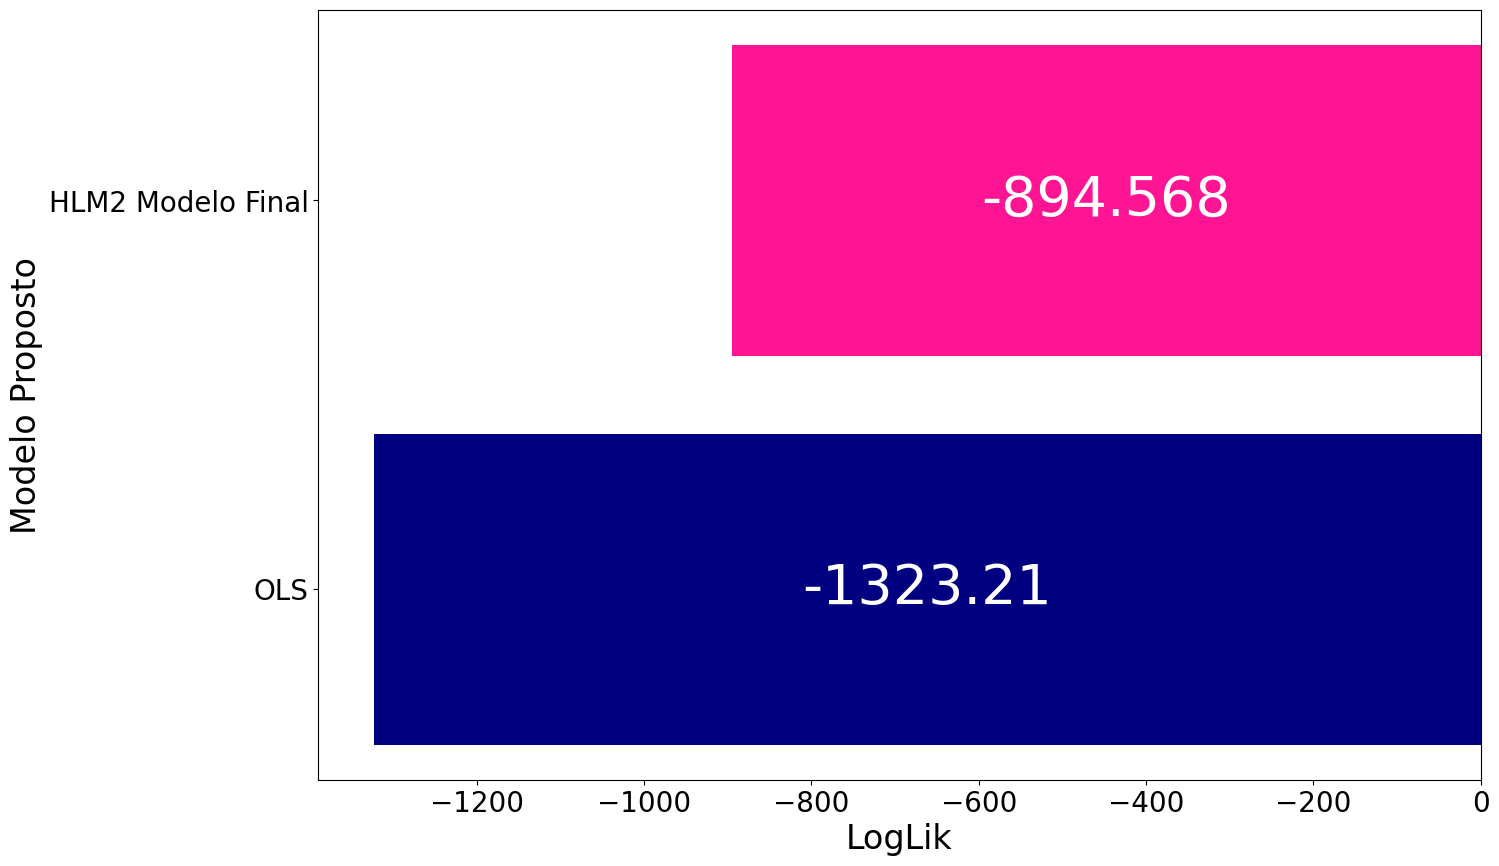

In [47]:
# In[1.38]: Gráfico para comparação visual dos logLiks dos modelos HLM2 Final
#e OLS
df_llf = pd.DataFrame({'modelo': ['OLS', 'HLM2 Modelo Final'],
                       'loglik': [modelo_ols.llf, modelo_final_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15, 10))

colors = ['navy', 'deeppink']

ax1 = ax.barh(df_llf.modelo, df_llf.loglik, color=colors)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

plt.show()

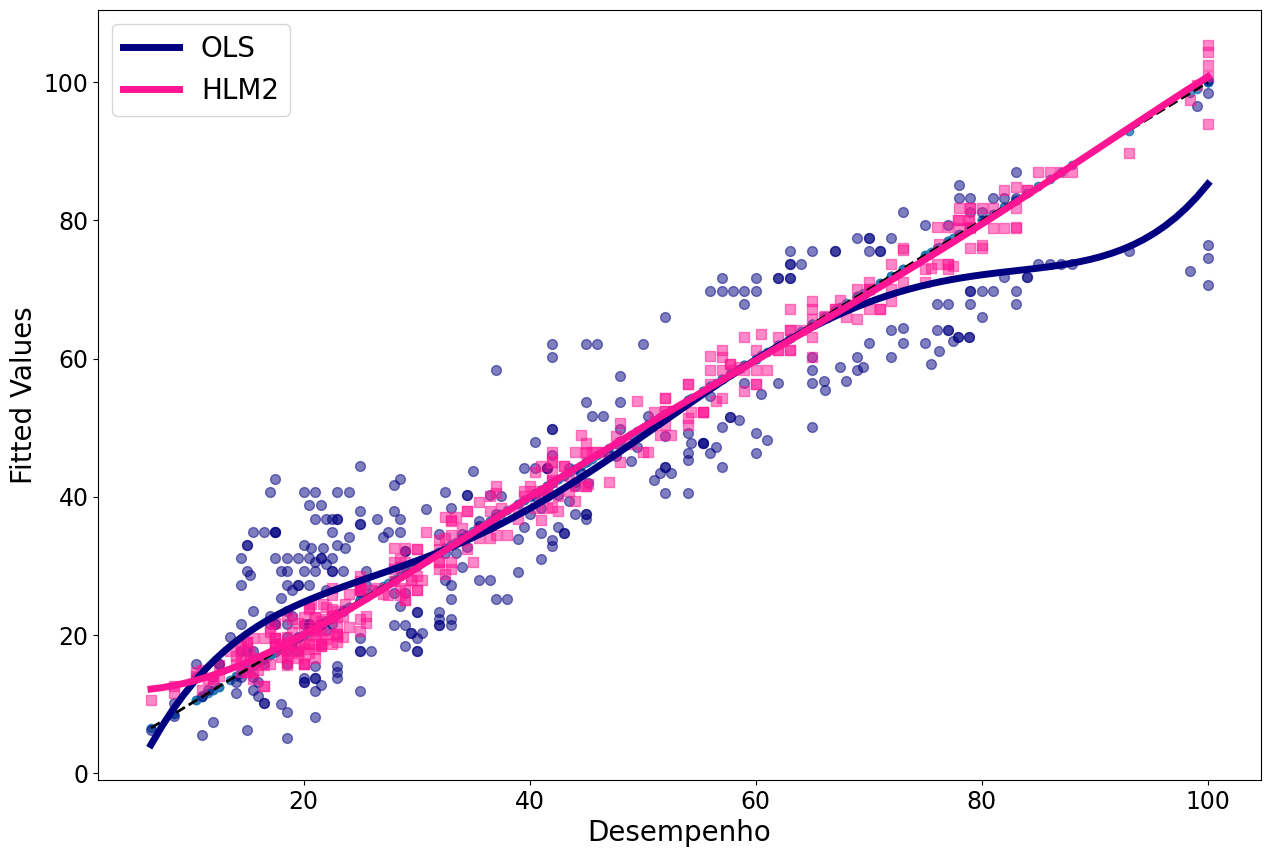

In [48]:
# In[1.39]: Gráfico para a comparação dos fitted values dos modelos HLM2 Final
#e OLS
plt.figure(figsize=(15,10))
sns.regplot(x=df_aluno_escola['desempenho'],
            y=df_aluno_escola['desempenho'],
            ci=None,
            line_kws={'color':'black', 'linewidth':2, 'linestyle':'--'})
sns.regplot(x=df_aluno_escola['desempenho'],
            y=modelo_ols.fittedvalues,
            ci=None, marker='o', order=5,
            scatter_kws={'color':'navy', 's':50, 'alpha':0.5},
            line_kws={'color':'navy', 'linewidth':5,
                      'label':'OLS'})
sns.regplot(x=df_aluno_escola['desempenho'],
            y=df_aluno_escola['fitted.completo'],
            ci=None, marker='s', order=5,
            scatter_kws={'color':'deeppink', 's':50, 'alpha':0.5},
            line_kws={'color':'deeppink', 'linewidth':5,
                      'label':'HLM2'})
plt.xlabel('Desempenho', fontsize=20)
plt.ylabel('Fitted Values', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=20)
plt.show()

## COMPARAÇÃO COM UM MODELO OLS COM DUMMIES                    #
Dummizando a variável 'escola'. O código abaixo automaticamente fará: 
- a) o estabelecimento de dummies que representarão cada uma das escolas do dataset;
- b) removerá a variável original a partir da qual houve a dummização;
- c) estabelecerá como categoria de referência a primeira categoria, ou seja, a escola '1' por meio do argumento 'drop_first=True'

In [49]:
# In[1.40]:
df_aluno_escola_dummies = pd.get_dummies(df_aluno_escola, columns=['escola'],
                                         dtype=int,
                                         drop_first=True)

df_aluno_escola_dummies.head(10)

,estudante,desempenho,horas,texp,fitted.fixed,fitted.completo,eij,escola_2,escola_3,escola_4,escola_5,escola_6,escola_7,escola_8,escola_9,escola_10
0,1,25.0,11,3.6,21.885819,26.501371,-1.501371,0,0,0,0,0,0,0,0,0
1,2,52.0,23,3.6,40.462363,50.343641,1.656359,0,0,0,0,0,0,0,0,0
2,3,52.0,25,3.6,43.558453,54.317353,-2.317353,0,0,0,0,0,0,0,0,0
3,4,30.0,14,3.6,26.529955,32.461938,-2.461938,0,0,0,0,0,0,0,0,0
4,5,51.0,24,3.6,42.010408,52.330497,-1.330497,0,0,0,0,0,0,0,0,0
5,6,25.0,11,3.6,21.885819,26.501371,-1.501371,0,0,0,0,0,0,0,0,0
6,7,15.0,5,3.6,12.597547,14.580235,0.419765,0,0,0,0,0,0,0,0,0
7,8,18.0,7,3.6,15.693638,18.553947,-0.553947,0,0,0,0,0,0,0,0,0
8,9,21.0,9,3.6,18.789728,22.527659,-1.527659,0,0,0,0,0,0,0,0,0
9,10,65.0,28,3.6,48.202589,60.277921,4.722079,0,0,0,0,0,0,0,0,0


In [50]:
# In[1.41]: Estimação do modelo de regressão múltipla com n-1 dummies
# Definição da fórmula utilizada no modelo
lista_colunas = list(df_aluno_escola_dummies.drop(columns=['estudante','desempenho',
                                                           'fitted.fixed',
                                                           'fitted.completo',
                                                           'eij']).columns)

formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "desempenho ~ " + formula_dummies_modelo
print("Fórmula utilizada: ",formula_dummies_modelo)

Fórmula utilizada:  desempenho ~ horas + texp + escola_2 + escola_3 + escola_4 + escola_5 + escola_6 + escola_7 + escola_8 + escola_9 + escola_10


In [51]:
# In[1.42]: Estimação do modelo com n-1 dummies propriamente dito
modelo_ols_dummies = sm.OLS.from_formula(formula_dummies_modelo,
                                               df_aluno_escola_dummies).fit()

# Parâmetros do 'modelo_ols_dummies'
modelo_ols_dummies.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     575.7
Date:                Thu, 03 Oct 2024   Prob (F-statistic):          2.81e-209
Time:                        10:14:12   Log-Likelihood:                -1120.2
No. Observations:                 358   AIC:                             2262.
Df Residuals:                     347   BIC:                             2305.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.0528      1.352     -8.175      0.000     -13.712      -8.394
horas          1.9713      0.056     35.063      0.000       1.861       2.082
texp           4.4516      0.096     46.582      0.000       4.264       4.640
escola_2     -14.6664      1.452    -10.101      0.000     -17.522     -11.811
escola_3      -7.2914      0.685    -10.651      0.000      -8.638      -5.945
escola_4      -0.7854      1.443     -0.544      0.587      -3.624       2.053
escola_5     -14.8095      1.238    -11.967      0.000     -17.244     -12.375
escola_6      -3.3658      1.321     -2.548      0.011      -5.964      -0.768
escola_7       2.3462      1.115      2.103      0.036       0.152       4.540
escola_8       4.5433      1.130      4.021      0.000       2.321       6.766
escola_9     -24.6820      1.323    -18.657      0.000     -27.284     -22.080
escola_10    -11.9232      1.310     -9.099      0.000     -14.501      -9.346
==============================================================================
Omnibus:                       14.171   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               32.665
Skew:                           0.002   Prob(JB):                     8.07e-08
Kurtosis:                       4.480   Cond. No.                     6.88e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.21e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Procedimento Stepwise para o 'modelo_ols_dummies'

In [52]:
# In[1.43]
# Carregamento da função 'stepwise' do pacote 'statstests.process'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/
from statstests.process import stepwise

# Estimação do modelo por meio do procedimento Stepwise
modelo_ols_dummies_step = stepwise(modelo_ols_dummies, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 desempenho ~ Q('horas') + Q('texp') + Q('escola_2') + Q('escola_3') + Q('escola_4') + Q('escola_5') + Q('escola_6') + Q('escola_7') + Q('escola_8') + Q('escola_9') + Q('escola_10')

 Discarding atribute "Q('escola_4')" with p-value equal to 0.5866607155055688 

Estimating model...: 
 desempenho ~ Q('horas') + Q('texp') + Q('escola_2') + Q('escola_3') + Q('escola_5') + Q('escola_6') + Q('escola_7') + Q('escola_8') + Q('escola_9') + Q('escola_10')

 Discarding atribute "Q('escola_3')" with p-value equal to 0.638511306980294 

Estimating model...: 
 desempenho ~ Q('horas') + Q('texp') + Q('escola_2') + Q('escola_5') + Q('escola_6') + Q('escola_7') + Q('escola_8') + Q('escola_9') + Q('escola_10')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('escola_4')", 'p-value': np.float64(0.5866607155055688)}
{'atribute': "Q('escola_3')", 'p-value': np.float64(0.638511306980294)}

 Model after 

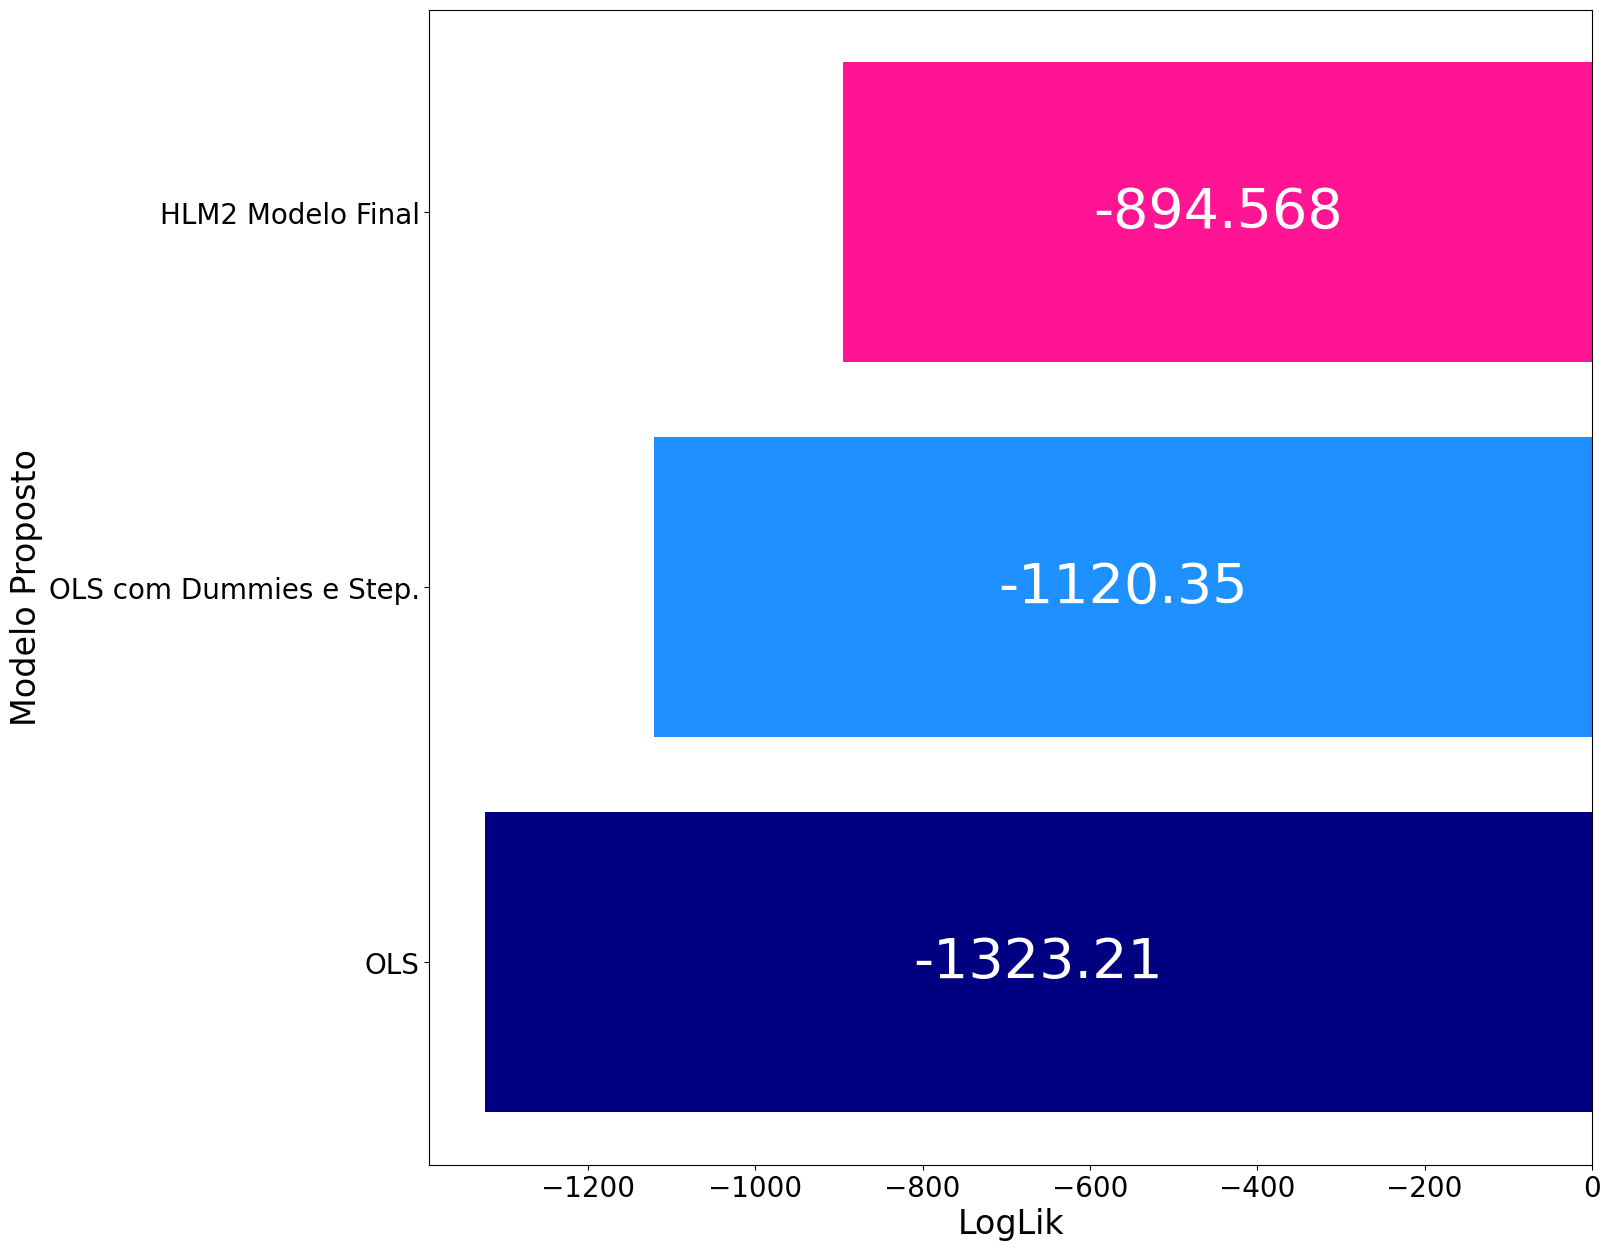

In [53]:
# In[1.44]: Gráfico para comparação visual dos logLiks dos modelos HLM2 Final,
#OLS e OLS com Dummies e Stepwise
df_llf = pd.DataFrame({'modelo':['OLS',
                                 'OLS com Dummies e Step.',
                                 'HLM2 Modelo Final'],
                      'loglik':[modelo_ols.llf,
                                modelo_ols_dummies_step.llf,
                                modelo_final_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['navy','dodgerblue','deeppink']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

In [54]:
# In[1.45]: Comparação entre os parâmetros dos modelos (atente-se para a
#quantidade de parâmetros estimados em cada um deles!)
summary_col([modelo_ols_dummies_step, modelo_final_hlm2],
            model_names=["OLS com Dummies","HLM2 Final"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs)),
                'Log-lik':lambda x: "{:.2f}".format(x.llf)
                })

,OLS com Dummies,HLM2 Final
Intercept,-8.1412***,-0.8496
,(1.4895),(2.9987)
Q('horas'),1.9774***,
,(0.0547),
Q('texp'),3.6635***,
,(0.1203),
Q('escola_2'),-16.0388***,
,(1.4151),
Q('escola_5'),-16.3362***,
,(1.1957),


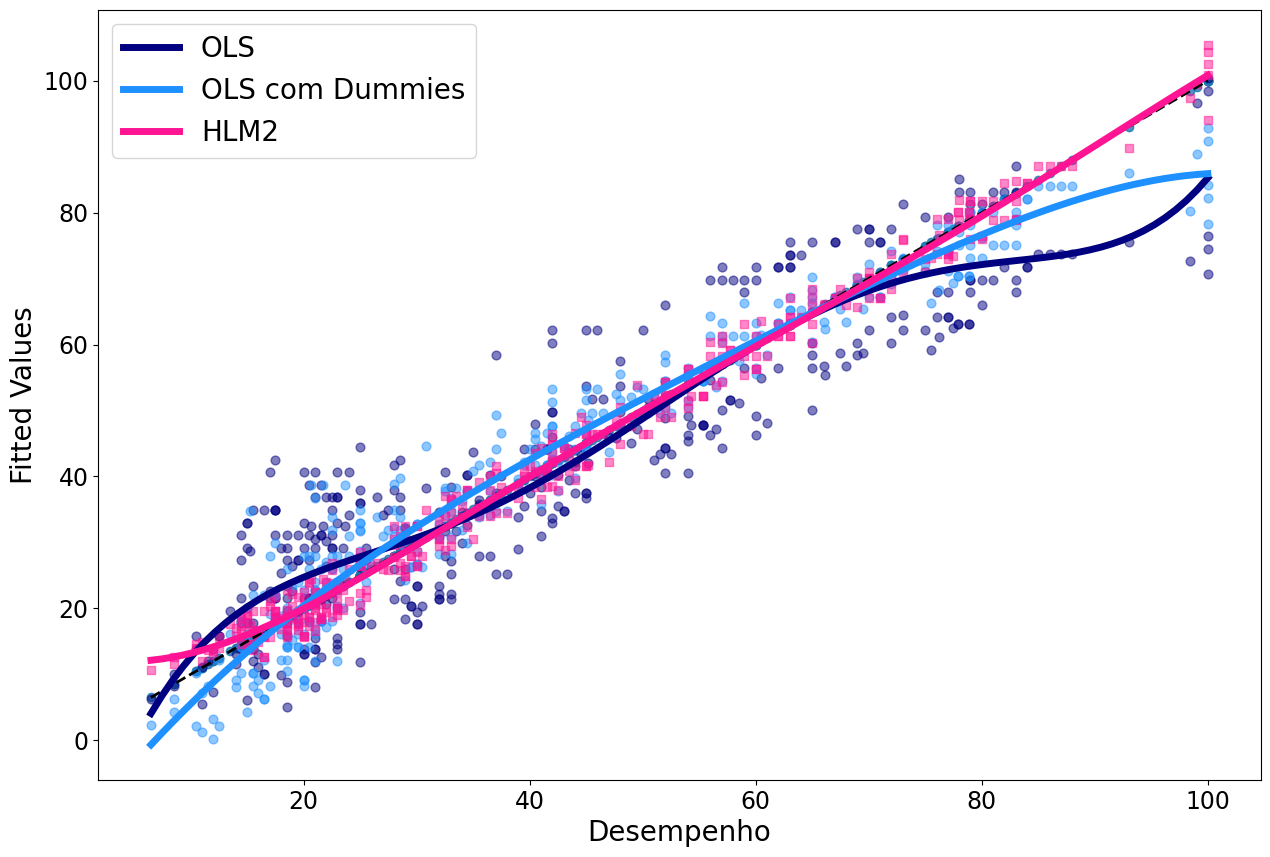

In [55]:
# In[1.46]: Gráfico para a comparação entre os fitted values dos modelos
#HLM2 Final, OLS e OLS com Dummies e Procedimento Stepwise
plt.figure(figsize=(15,10))
sns.regplot(x=df_aluno_escola['desempenho'],
            y=df_aluno_escola['desempenho'],
            ci=None,
            line_kws={'color':'black', 'linewidth':2, 'linestyle':'--'})
sns.regplot(x=df_aluno_escola['desempenho'],
            y=modelo_ols.fittedvalues,
            ci=None, marker='o', order=5,
            scatter_kws={'color':'navy', 's':40, 'alpha':0.5},
            line_kws={'color':'navy', 'linewidth':5,
                      'label':'OLS'})
sns.regplot(x=df_aluno_escola['desempenho'],
            y=modelo_ols_dummies_step.fittedvalues,
            ci=None, marker='o', order=5,
            scatter_kws={'color':'dodgerblue', 's':40, 'alpha':0.5},
            line_kws={'color':'dodgerblue', 'linewidth':5,
                      'label':'OLS com Dummies'})
sns.regplot(x=df_aluno_escola['desempenho'],
            y=df_aluno_escola['fitted.completo'],
            ci=None, marker='s', order=5,
            scatter_kws={'color':'deeppink', 's':40, 'alpha':0.5},
            line_kws={'color':'deeppink', 'linewidth':5,
                      'label':'HLM2'})
plt.xlabel('Desempenho', fontsize=20)
plt.ylabel('Fitted Values', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=20)
plt.show()

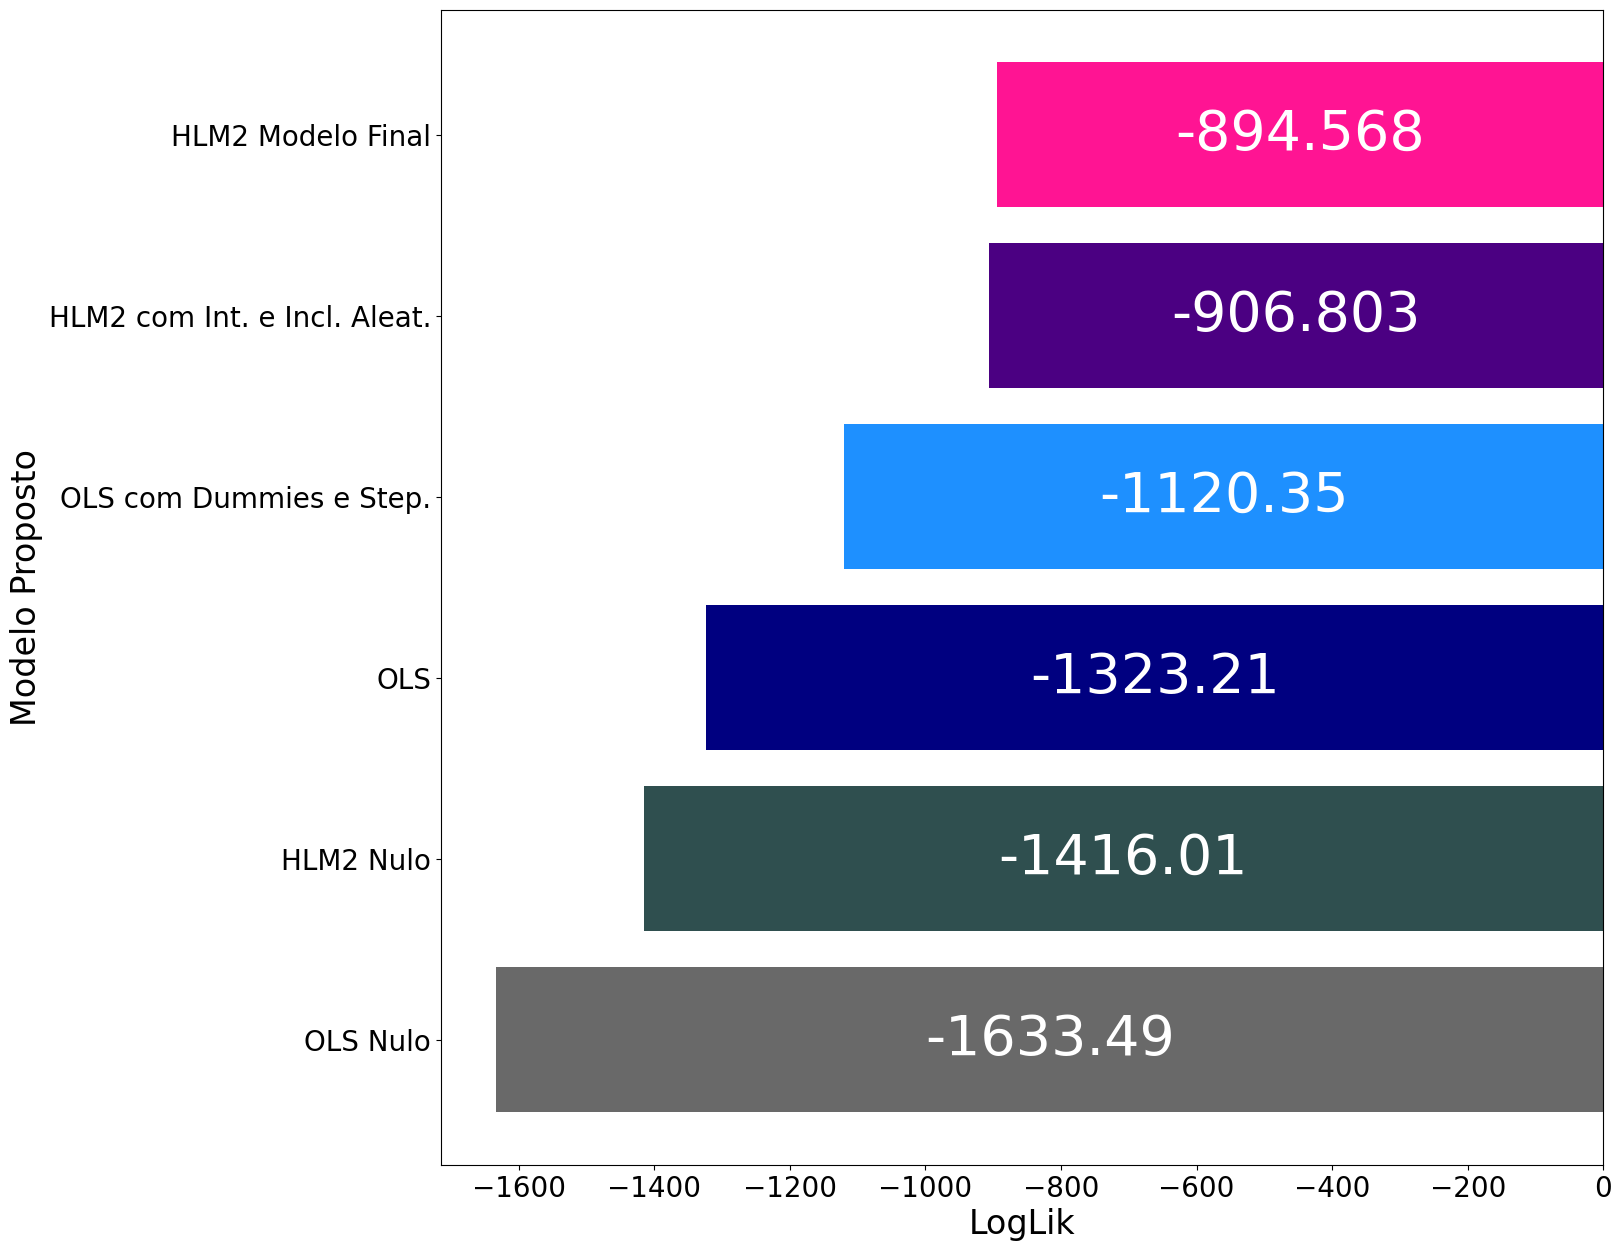

In [56]:
# In[1.47]: Gráfico para comparação visual dos logLiks de todos os modelos
#estimados neste exemplo
df_llf = pd.DataFrame({'modelo':['OLS Nulo','HLM2 Nulo','OLS',
                                 'OLS com Dummies e Step.',
                                 'HLM2 com Int. e Incl. Aleat.',
                                 'HLM2 Modelo Final'],
                      'loglik':[modelo_ols_nulo.llf,modelo_nulo_hlm2.llf,
                                modelo_ols.llf,
                                modelo_ols_dummies_step.llf,
                                modelo_intercept_inclin_hlm2.llf,
                                modelo_final_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['dimgray','darkslategray','navy','dodgerblue','indigo','deeppink']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()

### Modelos OLS com dummies e interação horas:texp


In [57]:
formula_dummies_modelo2 = ' + '.join(lista_colunas) + ' + horas:texp'
formula_dummies_modelo2 = 'desempenho ~ ' + formula_dummies_modelo2
print("Fórmula utilizada: ", formula_dummies_modelo2)

Fórmula utilizada:  desempenho ~ horas + texp + escola_2 + escola_3 + escola_4 + escola_5 + escola_6 + escola_7 + escola_8 + escola_9 + escola_10 + horas:texp


In [59]:
modelo_ols_dummies2 = sm.OLS.from_formula(formula_dummies_modelo2,
                                          df_aluno_escola_dummies).fit()
modelo_ols_dummies2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             desempenho   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1134.
Date:                Thu, 03 Oct 2024   Prob (F-statistic):          8.66e-264
Time:                        11:34:25   Log-Likelihood:                -986.91
No. Observations:                 358   AIC:                             1998.
Df Residuals:                     346   BIC:                             2044.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5565      1.261      4.405      0.000       3.075       8.038
horas          0.8306      0.070     11.859      0.000       0.693       0.968
texp           1.3486      0.172      7.851      0.000       1.011       1.686
escola_2     -11.8836      1.012    -11.743      0.000     -13.874      -9.893
escola_3      -8.2138      0.475    -17.301      0.000      -9.148      -7.280
escola_4      -2.2088      0.999     -2.212      0.028      -4.173      -0.245
escola_5     -12.1903      0.864    -14.102      0.000     -13.890     -10.490
escola_6      -2.9843      0.912     -3.273      0.001      -4.778      -1.191
escola_7       0.5424      0.775      0.700      0.485      -0.982       2.067
escola_8      -1.9272      0.847     -2.275      0.023      -3.593      -0.261
escola_9     -18.7334      0.962    -19.469      0.000     -20.626     -16.841
escola_10    -10.3706      0.908    -11.424      0.000     -12.156      -8.585
horas:texp     0.2232      0.011     19.563      0.000       0.201       0.246
==============================================================================
Omnibus:                       18.488   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.104
Skew:                          -0.278   Prob(JB):                     1.45e-08
Kurtosis:                       4.453   Cond. No.                     3.86e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.14e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [61]:
# Estimação do modelo por meio do procedimento Stepwise
modelo_ols_dummies_step2 = stepwise(modelo_ols_dummies2, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 desempenho ~ Q('horas') + Q('texp') + Q('escola_2') + Q('escola_3') + Q('escola_4') + Q('escola_5') + Q('escola_6') + Q('escola_7') + Q('escola_8') + Q('escola_9') + Q('escola_10') + Q('horas:texp')

 Discarding atribute "Q('escola_7')" with p-value equal to 0.4845600538337932 

Estimating model...: 
 desempenho ~ Q('horas') + Q('texp') + Q('escola_2') + Q('escola_3') + Q('escola_4') + Q('escola_5') + Q('escola_6') + Q('escola_8') + Q('escola_9') + Q('escola_10') + Q('horas:texp')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('escola_7')", 'p-value': np.float64(0.4845600538337932)}

 Model after stepwise process...: 
 desempenho ~ Q('horas') + Q('texp') + Q('escola_2') + Q('escola_3') + Q('escola_4') + Q('escola_5') + Q('escola_6') + Q('escola_8') + Q('escola_9') + Q('escola_10') + Q('horas:texp') 

                            OLS Regression Results                            
D

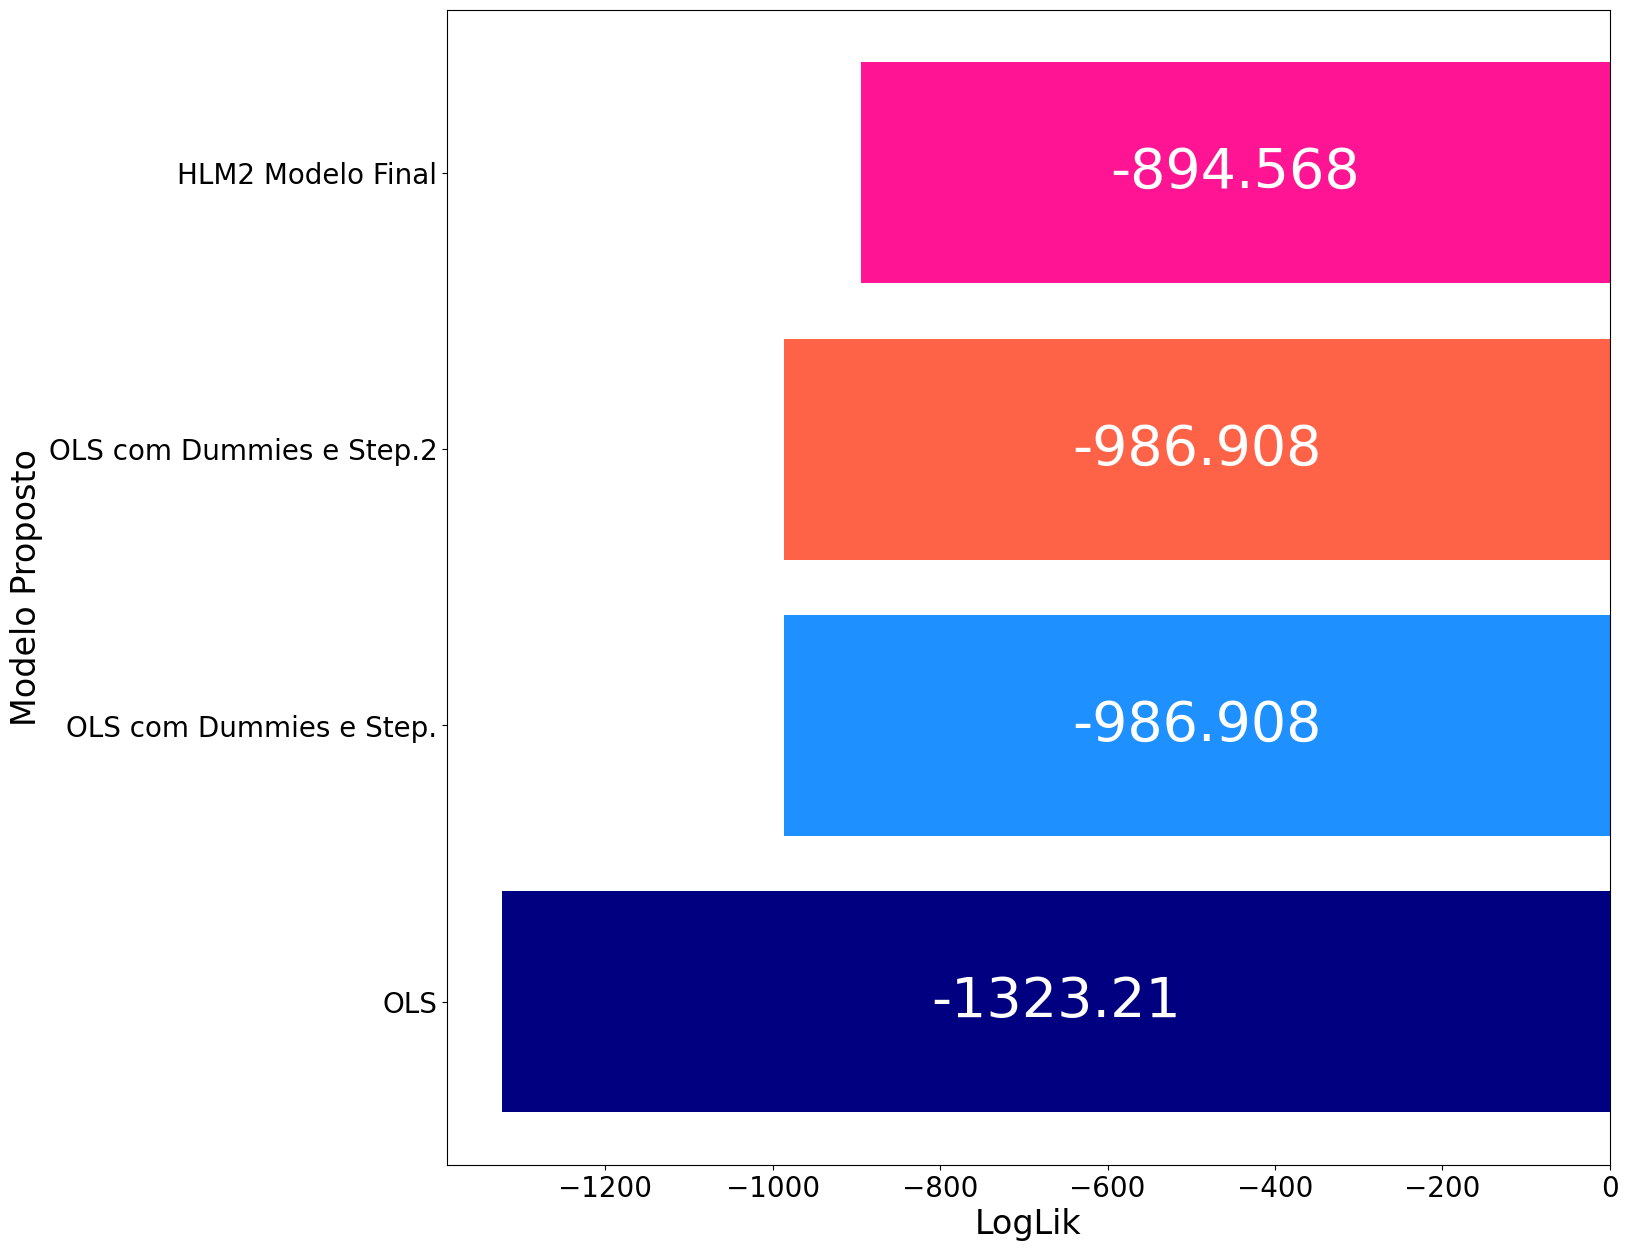

In [64]:
df_llf = pd.DataFrame({'modelo':['OLS',
                                 'OLS com Dummies e Step.',
                                 'OLS com Dummies e Step.2',
                                 'HLM2 Modelo Final'],
                      'loglik':[modelo_ols.llf,
                                modelo_ols_dummies_step.llf,
                                modelo_ols_dummies_step2.llf,
                                modelo_final_hlm2.llf]})

fig, ax = plt.subplots(figsize=(15,15))

c = ['navy','dodgerblue','tomato','deeppink']

ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
ax.bar_label(ax1, label_type='center', color='white', fontsize=40)
ax.set_ylabel("Modelo Proposto", fontsize=24)
ax.set_xlabel("LogLik", fontsize=24)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
plt.show()